<a href="https://colab.research.google.com/github/tsc2017/MIX-GAN/blob/main/MIX-MHingeGAN-CIFAR-10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Mon Oct 19 03:06:39 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    25W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Mounting Google Drive ↖here would be simpler if you are the creator of a notebook. Maybe you can create a new notebook and copy the cells.
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
# Monitor GPU Utilization, GPU temp, etc
#!pip install wandb
#import wandb
#wandb.init()

In [4]:
pip install tensorflow-gan

     |████████████████████████████████| 368kB 6.0MB/s 


In [5]:
# GPUs with Tensor Cores can benefit from mixed-precision training substancially
!export TF_ENABLE_AUTO_MIXED_PRECISION=1

In [6]:
import os, sys
# The "tflib" directory is in os.environ['HOME']; the datasets are in os.environ['DATA']. The log directory will be created automatically if it does not exist.
os.environ['HOME']="/content/drive/Shared drives/shared/mix-gan" # My Drive or Shared drives
os.environ['DATA']="/content/drive/Shared drives/shared/mix-gan/data" 
os.environ['LOG']="/content/drive/Shared drives/shared/mix-gan/logs" 

In [7]:
%cd /content/drive/Shared drives/shared/mix-gan/data
# Download and extract the CIFAR-10 dataset automatically if it does not exist
if not os.path.isfile(os.environ['DATA']+'/cifar-10-python.tar.gz'):
  !wget www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
  !tar vxzf cifar-10-python.tar.gz
%cd ..

/content/drive/Shared drives/shared/mix-gan/data
/content/drive/Shared drives/shared/mix-gan


In [8]:
import tensorflow.compat.v1 as tf
import os, sys
sys.path.append(os.getcwd())
gpu_id=[0]
DEVICES = ['/gpu:{}'.format(i) for i in range(len(gpu_id))]
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]=','.join([str(i) for i in gpu_id]) #set gpu id
import random
import time

import functools
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import numpy as np
import sklearn.datasets
import scipy.misc
import urllib
import tflib as lib
import tflib.ops.linear
import tflib.ops.conv2d
import tflib.ops.batchnorm
import tflib.ops.cond_batchnorm
import tflib.ops.layernorm
import tflib.ops.deconv2d
import tflib.save_images
import tflib.mnist
import tflib.cifar10
#import tflib.cifar100
import tflib.imagenet64
import tflib.imagenet128_10classes
import tflib.imagenet128
import tflib.small_imagenet
#import tflib.stl
from tflib.ada import augment
import tflib.plot
import tflib.inception_score
import tflib.fid
import errno
#from cleverhans.attacks_tf import fgsm
import locale
dtype='float32'

DATASET = 'CIFAR-10' #CIFAR, small_ImageNet, ImageNet64, ImageNet128_10classes, ImageNet128, STL

gan_learning_rate=2e-4

NUM_GENERATORS=10
NUM_DISCRIMINATORS=10

# For WGAN-GP
BASE_DIM=8
G_DIM = 32*BASE_DIM # Generator dimensionality
D_DIM = 32*BASE_DIM  # Discriminator dimensionality

RAND_LABELS=False
SHARED_EMBED=1
PL_COEFF=0
HIER=1
ATTENTION=0
NUM_RESIDUAL_UNIT=1
BOTTLENECK=0
GET_LABELS=True
BATCH_SIZE = 50 # Batch size, must be divisible by the dataset size if using MNIST 
GET_INCEPTION_SCORE=1
GET_FID=1
INCEPTION_BATCHES=int(50000/BATCH_SIZE)
FID_BATCHES=int(50000/BATCH_SIZE)
TRAIN_SIZE=BATCH_SIZE*1 # Define the training set size, ignored if using a realistic image dataset
TEST_SIZE=BATCH_SIZE*1 # Define the test set size, ignored if using a realistic image dataset
LAMBDA =0 # Smaller lambda makes things faster for toy tasks, but isn't necessary if you increase N_CRITIC enough
R1_COEFF=0
################################################
GAN_LOSS=False
HINGE_LOSS=False
WGAN_LOSS=False
AM_LOSS=False
MH_LOSS=True
assert GAN_LOSS + HINGE_LOSS + WGAN_LOSS + AM_LOSS + MH_LOSS == 1
############################################
#settings
ADA=False
ADA_TARGET=.6
REC_NORM=2 # useless and need not be changed
REC_COEFF=0
ORTH_COEFF=0
LAMBDA3=0.05
Z_DIM=120

N_GENERATOR = 1 # Generator steps per general steps
N_CRITIC = 4 # Critic steps per general steps
ITERS=100000
EMA=True
EMA_ITER=2000
ACCU_STATS=True
snapshot_interval=5000
log_interval=1000
num_modal=3
std=.0# noise strength in CMNIST


LAMBDA2 = 0  # parameter LAMBDA2 for CT-GAN
DROPOUT=1 if LAMBDA2>0 else 0
Factor_M = 0.0  # factor M
NORMALIZATION_G = True # Use batchnorm in generator?
NORMALIZATION_D = False # Use batchnorm (or layernorm) in critic?
DECAY = True # Whether to decay LR over learning
SPECTRAL_NORMALIZATION = True
CONDITIONAL = True  # Whether to train a conditional or unconditional model

ACGAN_SCALE = 0 # How to scale the critic's ACGAN loss relative to WGAN loss
ACGAN_SCALE_G = .0 # How to scale generator's ACGAN loss relative to WGAN loss
ACGAN = ACGAN_SCALE!=0

BETA1=0.
BETA2=.9
STYLEGAN=False
STYLEGAN2=False
if STYLEGAN or STYLEGAN2: Z_DIM=512
if STYLEGAN2:
    GAN_LOSS=1
    MH_LOSS=False
    HINGE_LOSS=False
    WGAN_LOSS=0
    AM_LOSS=False
    R1_COEFF=0.01
    RAND_LABELS=True
    ACCU_STATS=False
    LAMBDA3=0
    N_CRITIC = 1
    BATCH_SIZE=64
    BETA2= .99
    gan_learning_rate=2.5e-3
    ITERS=100e6//BATCH_SIZE
COMPUTE_GRADIENT = LAMBDA>0 or R1_COEFF>0
locale.setlocale(locale.LC_ALL, '')
lib.print_model_settings(locals().copy())

Instructions for updating:
non-resource variables are not supported in the long term

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:04.0, compute capability: 7.0

Instructions for updating:
Use keras.layers.Flatten instead.


Instructions for updating:
Use keras.layers.Flatten instead.


Instructions for updating:
Please use `layer.__call__` method instead.


Instructions for updating:
Please use `layer.__call__` method instead.


Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:04.0, compute capability: 7.0

Uppercase local vars:
	ACCU_STATS: True
	ACGAN: False
	ACGAN_SCALE: 0
	ACGAN_SCALE_G: 0.0
	ADA: False
	ADA_TARGET: 0.6
	AM_LOSS: False
	ATTENTION: 0
	BASE_DIM: 8
	BATCH_SIZE: 50
	BETA1: 0.0
	BETA2: 0.9
	BOTTLENECK: 0
	COMPUTE_GRADIENT: False
	CONDITIONAL: True
	DATASET: CIFAR-10
	DECAY: True
	DEVICES: ['/gpu:0']
	DROPOUT: 0
	D_DIM: 256
	EMA: True
	EMA_ITER: 2000
	FID_BATCHES: 1000
	GAN_LOSS: False
	GET_FID: 1
	GET_INCEPTION_SCORE: 1
	GET_LABELS: True
	G_DIM: 256
	HIER: 1
	HINGE_LOSS: False
	INCEPTION_BATCHES: 1000
	ITERS: 100000
	LAMBDA: 0
	LAMBDA2: 0
	LAMBDA3: 0.05
	MH_LOSS: True
	NORMALIZATION_D: False
	NORMALIZATION_G: True
	NUM_DISCRIMINATORS: 10
	NUM_GENERATORS: 10
	NUM_RESIDUAL_UNI

In [9]:
tf.__version__

'2.3.0'

In [10]:
#Datasets
IMAGE_DATASETS=['MNIST','CMNIST','CIFAR-10', 'ImageNet64', 'ImageNet128_10classes', 'ImageNet128','small_ImageNet','STL','STL32','STL48','STL64','STL128','Zap50k']
ENCODER_MODELS=['ALI','IDGAN']

assert DATASET in IMAGE_DATASETS or NETWORK_TYPE is 'FCGAN', 'Cannot use DCGAN for non-image datasets.'

if DATASET=='MNIST':
    NUM_CHANNELS=1
    HEIGHT=WIDTH=32
    DATA_DIM=HEIGHT*WIDTH*NUM_CHANNELS
    TRAIN_SIZE=50000
    TEST_SIZE=10000
if DATASET=='CMNIST':
    NUM_CHANNELS=3
    HEIGHT=WIDTH=32
    DATA_DIM=HEIGHT*WIDTH*NUM_CHANNELS
    SKETCH_DIM=HEIGHT*WIDTH
    TRAIN_SIZE=50000
    TEST_SIZE=10000
if DATASET=='CIFAR-10':
    NUM_CHANNELS=3
    HEIGHT=WIDTH=32
    DATA_DIM=HEIGHT*WIDTH*NUM_CHANNELS
    NUM_CLASSES=10
    CODE_DIM=10
    TRAIN_SIZE=50000
    TEST_SIZE=10000
    # Download CIFAR-10 (Python version) at
    # https://www.cs.toronto.edu/~kriz/cifar.html and fill in the path to the
    # extracted files here!
    DATA_DIR = os.environ['DATA']+'/cifar-10-batches-py/'#directory to save the dataset

if DATASET=='ImageNet64':
    NUM_CHANNELS=3
    HEIGHT=WIDTH=64
    DATA_DIM=HEIGHT*WIDTH*NUM_CHANNELS
    NUM_CLASSES=1000
    CODE_DIM=NUM_CLASSES
    TRAIN_SIZE=1281167
    TEST_SIZE=50000
    DATA_DIR = os.environ['DATA']+'/ImageNet64/'#directory to save the dataset
    
if DATASET=='ImageNet128_10classes':
    NUM_CHANNELS=3
    HEIGHT=WIDTH=128
    DATA_DIM=HEIGHT*WIDTH*NUM_CHANNELS
    NUM_CLASSES=10
    CODE_DIM=NUM_CLASSES
    TRAIN_SIZE=12697
    TEST_SIZE=500
    DATA_DIR = os.environ['DATA']+'/ImageNet128_10classes/'#directory to save the dataset
    
if DATASET=='ImageNet128':
    NUM_CHANNELS=3
    HEIGHT=WIDTH=128
    DATA_DIM=HEIGHT*WIDTH*NUM_CHANNELS
    NUM_CLASSES=1000
    CODE_DIM=NUM_CLASSES
    TRAIN_SIZE=1281159
    TEST_SIZE=50000
    DATA_DIR = os.environ['DATA']+'/ImageNet128/'#directory to save the dataset
    
if DATASET=='small_ImageNet':
    NUM_CHANNELS=3
    HEIGHT=WIDTH=64
    DATA_DIM=HEIGHT*WIDTH*NUM_CHANNELS
    NUM_CLASSES=1000
    CODE_DIM=NUM_CLASSES
    TRAIN_SIZE=1281150
    TEST_SIZE=50000
    # Download 64x64 small_ImageNet at http://image-net.org/small/download.php and
    # fill in the path to the extracted files here!
    DATA_DIR = os.environ['DATA']+'/small_ImageNet/' #directory to save the dataset

if DATASET=='STL':
    NUM_CHANNELS=3
    HEIGHT=WIDTH=96
    DATA_DIM=HEIGHT*WIDTH*NUM_CHANNELS
    NUM_CLASSES=10
    CODE_DIM=10
    TRAIN_SIZE=5000
    TEST_SIZE=8000
    # fill in the path to the extracted files here!
    DATA_DIR = os.environ['DATA']+'/STL-10/stl10_matlab/' #directory to save the dataset
    
if DATASET=='STL32':
    NUM_CHANNELS=3
    HEIGHT=WIDTH=32
    DATA_DIM=HEIGHT*WIDTH*NUM_CHANNELS
    NUM_CLASSES=10
    CODE_DIM=10
    TRAIN_SIZE=5000
    TEST_SIZE=8000
    # fill in the path to the extracted files here!
    DATA_DIR = os.environ['DATA']+'/STL-10/stl10_matlab/' #directory to save the dataset    
if DATASET=='STL48':
    NUM_CHANNELS=3
    HEIGHT=WIDTH=48
    DATA_DIM=HEIGHT*WIDTH*NUM_CHANNELS
    NUM_CLASSES=10
    CODE_DIM=10
    TRAIN_SIZE=5000
    TEST_SIZE=8000
    # fill in the path to the extracted files here!
    DATA_DIR = os.environ['DATA']+'/STL-10/stl10_matlab/' #directory to save the dataset  
if DATASET=='STL64':
    NUM_CHANNELS=3
    HEIGHT=WIDTH=64
    DATA_DIM=HEIGHT*WIDTH*NUM_CHANNELS
    NUM_CLASSES=10
    CODE_DIM=10
    TRAIN_SIZE=5000
    TEST_SIZE=8000
    # fill in the path to the extracted files here!
    DATA_DIR = os.environ['DATA']+'/STL-10/stl10_matlab/' #directory to save the dataset  
if DATASET=='STL128':
    NUM_CHANNELS=3
    HEIGHT=WIDTH=128
    DATA_DIM=HEIGHT*WIDTH*NUM_CHANNELS
    NUM_CLASSES=10
    CODE_DIM=10
    TRAIN_SIZE=5000
    TEST_SIZE=8000
    # fill in the path to the extracted files here!
    DATA_DIR = os.environ['DATA']+'/STL-10/stl10_matlab/' #directory to save the dataset  
if DATASET=='Zap50k':
    NUM_CHANNELS=3
    REAL_HEIGHT=102
    REAL_WIDTH=136
    HEIGHT=WIDTH=128
    DATA_DIM=HEIGHT*WIDTH*NUM_CHANNELS
    SKETCH_DIM=HEIGHT*WIDTH
    TRAIN_SIZE=40000
    TEST_SIZE=10025
    DATA_DIR = os.environ['DATA']+'/ut-zap50k/ut-zap50k-images-unfolded'#directory to save the dataset
    SKETCH_DIR =os.environ['DATA']+'/ut-zap50k/ut-zap50k-sketches-unfolded'

if DATASET in IMAGE_DATASETS:
    G_LAYERS=int(np.ceil(np.log2(HEIGHT/4)))+2

# Dataset iterator
def inf_gen(MODE='TRAIN'):
    if DATASET == '25gaussians':
    
        dataset = []
        for i in range(100000/25):
            for x in range(-2, 3):
                for y in range(-2, 3):
                    point = np.random.randn(2)*0.05
                    point[0] += 2*x
                    point[1] += 2*y
                    dataset.append(point)
        dataset = np.array(dataset, dtype=dtype)
        np.random.shuffle(dataset)
        dataset /= 2.828 # stdev
        while True:
            for i in range(len(dataset)/BATCH_SIZE):
                yield dataset[i*BATCH_SIZE:(i+1)*BATCH_SIZE]

    elif DATASET == 'swissroll':

        while True:
            data = sklearn.datasets.make_swiss_roll(
                n_samples=BATCH_SIZE, 
                ran_noise=0.25
            )[0]
            data = data.astype(dtype)[:, [0, 2]]
            data /= 7.5 # stdev plus a little
            yield data

    elif DATASET == '8gaussians':
    
        centers = [
            (1,0),
            (-1,0),
            (0,1),
            (0,-1),
            (1./np.sqrt(2), 1./np.sqrt(2)),
            (1./np.sqrt(2), -1./np.sqrt(2)),
            (-1./np.sqrt(2), 1./np.sqrt(2)),
            (-1./np.sqrt(2), -1./np.sqrt(2))
        ]
        centers = [(scale*x,scale*y) for x,y in centers]
        while True:
            dataset = []
            for i in range(BATCH_SIZE):
                point = np.random.randn(2)*.02
                center = random.choice(centers)
                point[0] += center[0]
                point[1] += center[1]
                dataset.append(point)
            dataset = np.array(dataset, dtype=dtype)
            dataset /= 1.414 # stdev
            yield dataset

            
    elif DATASET == 'n-gaussians':         
        centers = []
        for i in range(num_modal):
            centers.append(scale*tf.one_hot(i,DATA_DIM,dtype=dtype).eval())
                    
        if not FIX_DATA:
            while True:
                dataset = []
                points = np.random.randn(BATCH_SIZE, DATA_DIM)*std
                #points=tf.random_normal([BATCH_SIZE, DATA_DIM])*std
                #center_choice=np.zeros((BATCH_SIZE, DATA_DIM), dtype='float32')
                for i in range(BATCH_SIZE):
                    points[i][random.randint(0,num_modal-1)]+=1.
                #dataset = np.array(points, dtype='float32')
                #dataset /= 1.414 # stdev
                yield points
        else:            
            if MODE=='TRAIN':
                fixed_train_data=np.random.randn(TRAIN_SIZE, DATA_DIM)*std
                for i in range(TRAIN_SIZE):
                    fixed_train_data[i][random.randint(0,num_modal-1)]+=1.
                while True:
                    for i in range(fixed_train_data.shape[0]/BATCH_SIZE):
                        yield fixed_train_data[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
                        
            elif MODE=='TEST':
                fixed_test_data=np.random.randn(TEST_SIZE, DATA_DIM)*std
                for i in range(TEST_SIZE):
                    fixed_test_data[i][random.randint(0,num_modal-1)]+=1.
                while True:
                    for i in range(fixed_test_data.shape[0]/BATCH_SIZE):
                        yield fixed_test_data[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
            else:
                raise UnsupportedDataMode
            
    elif DATASET == 'ball':           
        if not FIX_DATA:
            while True:
                points=np.random.randn(BATCH_SIZE,DATA_DIM)
                dataset=points/np.linalg.norm(points,axis=1,keepdims=True)*scale
                yield dataset
        else:              
            if MODE=='TRAIN':
                fixed_train_data = np.random.randn(TRAIN_SIZE,DATA_DIM)
                fixed_train_data=fixed_train_data/np.linalg.norm(fixed_train_data,axis=1,keepdims=True)*scale
                while True:
                    for i in range(fixed_train_data.shape[0]/BATCH_SIZE):
                        yield fixed_train_data[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
            elif MODE=='TEST':
                fixed_test_data = np.random.randn(TEST_SIZE,DATA_DIM)
                fixed_test_data=fixed_test_data/np.linalg.norm(fixed_test_data,axis=1,keepdims=True)*scale
                while True:
                    for i in range(fixed_test_data.shape[0]/BATCH_SIZE):
                        yield fixed_test_data[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
            else:
                raise UnsupportedDataMode
    elif DATASET == 'net': 
        if not FIX_DATA:
            while True:
                yield session.run(real_gen_data)
        else:              
            if MODE=='TRAIN':
                fixed_train_data = Real_Gen(TRAIN_SIZE, real_data).eval()
                while True:
                    for i in range(fixed_train_data.shape[0]/BATCH_SIZE):
                        yield fixed_train_data[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
            elif MODE=='TEST':
                fixed_test_data = Real_Gen(TEST_SIZE, real_data).eval()
                while True:
                    for i in range(fixed_test_data.shape[0]/BATCH_SIZE):
                        yield fixed_test_data[i*BATCH_SIZE:(i+1)*BATCH_SIZE]
            else:
                raise UnsupportedDataMode
    elif DATASET=='MNIST':
        if MODE=='TRAIN':
            train_gen, _, _ = lib.mnist.load(BATCH_SIZE, BATCH_SIZE)
            while True:
                for images,targets in train_gen():
                    yield images*2-1
        elif MODE=='TEST':
            _, val_gen, _ = lib.mnist.load(BATCH_SIZE, BATCH_SIZE)
            while True:
                for images,targets in val_gen():
                    yield images*2-1
    elif DATASET=='CMNIST':
        if MODE=='TRAIN':
            train_gen, _, _ = lib.mnist.load(BATCH_SIZE, BATCH_SIZE)
            while True:
                for images,targets in train_gen():
                    if DENOISE:
                        images=np.tile(images.reshape(-1,1,HEIGHT,WIDTH),(1,3,1,1))
                        images=(images*np.random.rand(images.shape[0],3,1,1)).reshape(-1,DATA_DIM)*2-1
                        images+=std*np.random.randn(images.shape[0],images.shape[1])
                        images[images>1]=1
                        images[images<-1]=-1
                        yield images
                    else:
                        images=np.tile(images.reshape(-1,1,HEIGHT,WIDTH),(1,3,1,1))
                        yield (images*np.random.rand(images.shape[0],3,1,1)).reshape(-1,DATA_DIM)*2-1                   
        elif MODE=='TEST':
            _, val_gen, _ = lib.mnist.load(BATCH_SIZE, BATCH_SIZE)
            while True:
                for images,targets in val_gen():
                    if DENOISE:
                        images=np.tile(images.reshape(-1,1,HEIGHT,WIDTH),(1,3,1,1))
                        images=(images*np.random.rand(images.shape[0],3,1,1)).reshape(-1,DATA_DIM)*2-1
                        images+=std*np.random.randn(images.shape[0],images.shape[1])
                        images[images>1]=1
                        images[images<-1]=-1
                        yield images
                    else:
                        images=np.tile(images.reshape(-1,1,HEIGHT,WIDTH),(1,3,1,1))
                        yield (images*np.random.rand(images.shape[0],3,1,1)).reshape(-1,DATA_DIM)*2-1  
    elif DATASET=='CIFAR-10':
        if MODE=='TRAIN':
            train_gen, _ = lib.cifar10.load(BATCH_SIZE, data_dir=DATA_DIR)
            while True:
                for original_images, labels in train_gen():
                    yield 2./255*original_images-1,labels
        elif MODE=='TEST':
            _, test_gen = lib.cifar10.load(BATCH_SIZE, data_dir=DATA_DIR)
            while True:
                for original_images, labels in test_gen():
                    yield 2./255*original_images-1,labels
    elif DATASET=='ImageNet64':
            gen = lib.imagenet64.load(MODE, BATCH_SIZE, data_dir=DATA_DIR)
            while True:
                for original_images, labels in gen():
                    yield 2./255*original_images-1,labels
    elif DATASET=='ImageNet128':
            gen = lib.imagenet128.load(MODE, BATCH_SIZE, data_dir=DATA_DIR)
            while True:
                for original_images, labels in gen():
                    yield 2./255*original_images-1,labels
    elif DATASET=='ImageNet128_10classes':
            gen = lib.imagenet128_10classes.load(MODE, BATCH_SIZE, data_dir=DATA_DIR)
            while True:
                for original_images, labels in gen():
                    yield 2./255*original_images-1,labels
    elif DATASET=='small_ImageNet':
        if MODE=='TRAIN':
            train_gen, _ = lib.small_imagenet.load(BATCH_SIZE, data_dir=DATA_DIR)
            while True:
                for images in train_gen():
                    yield images[0].reshape((-1,DATA_DIM))*2./255-1, np.zeros([BATCH_SIZE])
        elif MODE=='TEST':
            _, test_gen = lib.small_imagenet.load(BATCH_SIZE, data_dir=DATA_DIR)
            while True:
                for images in test_gen():
                    yield images[0].reshape((-1,DATA_DIM))*2./255-1, np.zeros([BATCH_SIZE])
    elif 'STL' in DATASET:
            gen = lib.stl.load(MODE, BATCH_SIZE, data_dir=DATA_DIR, size=HEIGHT)
            while True:
                for original_images, labels in gen():
                    yield 2./255*original_images-1,labels
    elif DATASET=='Zap50k':
        perm_matrices=np.zeros((6,3,3))
        perm_matrices[0]=np.array([[1,0,0],[0,1,0],[0,0,1]])
        perm_matrices[1]=np.array([[1,0,0],[0,0,1],[0,1,0]])
        perm_matrices[2]=np.array([[0,1,0],[1,0,0],[0,0,1]])
        perm_matrices[3]=np.array([[0,1,0],[0,0,1],[1,0,0]])
        perm_matrices[4]=np.array([[0,0,1],[1,0,0],[0,1,0]])
        perm_matrices[5]=np.array([[0,0,1],[0,1,0],[1,0,0]])
        perm_matrices=perm_matrices.reshape(6,-1)
        if MODE=='TRAIN':
            perm=np.arange(TRAIN_SIZE)
            while True:
                np.random.shuffle(perm)
                for i in range(TRAIN_SIZE/BATCH_SIZE):
                    train_images,train_sketches=\
                    lib.ut_zap50k.load('TRAIN', DATA_DIR, SKETCH_DIR,[perm[j+i*BATCH_SIZE] for j in range(BATCH_SIZE)])                  
                    if PERMUTE_COLORS:
                        for j in range(BATCH_SIZE):
                            coeffs=np.zeros(COLOR_DIM)
                            coeffs[0]=np.random.rand()
                            for i in range(COLOR_DIM-1):
                                coeffs[i+1]=np.random.rand()*(1-np.sum(coeffs[:(i+1)]))
                            coeffs/=np.sum(coeffs)
                            np.random.shuffle(perm_matrices)
                            ds=np.matmul(coeffs,perm_matrices[:COLOR_DIM]).reshape(3,3)
                            train_images[j]=np.matmul(ds,train_images[j].reshape(3,-1)).reshape(3,train_images[j].shape[1],train_images[j].shape[2])    
                    yield train_images.reshape((-1,DATA_DIM))*2./255-1
        elif MODE=='TEST':
            perm=np.arange(TEST_SIZE)
            while True:
                np.random.shuffle(perm)
                for i in range(TEST_SIZE/BATCH_SIZE):
                    test_images,test_sketches=\
                    lib.ut_zap50k.load('TEST', DATA_DIR, SKETCH_DIR,[perm[j+i*BATCH_SIZE] for j in range(BATCH_SIZE)])
                    yield test_images.reshape((-1,DATA_DIM))*2./255-1
                    

In [11]:
if not RAND_LABELS:
    assert BATCH_SIZE % NUM_CLASSES==0
assert NUM_GENERATORS % len(gpu_id)==0

In [12]:
config=tf.ConfigProto(log_device_placement=True,allow_soft_placement=True)
config.graph_options.optimizer_options.global_jit_level = tf.OptimizerOptions.ON_1
from tensorflow.core.protobuf import rewriter_config_pb2
config.graph_options.rewrite_options.auto_mixed_precision = rewriter_config_pb2.RewriterConfig.ON
session=tf.Session(config=config)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:04.0, compute capability: 7.0



In [13]:
#Placeholders
with tf.device('/cpu:0'):
    real_data = tf.placeholder(dtype, shape=[None, DATA_DIM],name='real_data')
    rec_real_data=adv_x=real_data
    real_labels = tf.placeholder(tf.int32, shape=[None],name='real_labels')
    real_code = tf.one_hot(real_labels,NUM_CLASSES,dtype=dtype)

    lr = tf.placeholder(
           dtype, [],
            name='lr'
        )
    curr_iter=tf.placeholder(
           tf.int32, [],
            name='curr_iter'
        )
    update_p=tf.placeholder(
           tf.bool, [],
            name='update_p'
        )

In [14]:
#Utilities
def mkdir_p(path):
    try:
        os.makedirs(path)
    except OSError as exc:  # Python >2.5
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise
# where to load the snapshot, if you need to specify it, comment its subsequent line: #log_dir=''
load_dir='/mnt/Data/logs/test'
load_dir=''
log_dir=os.environ['LOG']+'/MIX-MHingeGAN-%iG%iD-CIFAR-10-conditional-%s/'\
%(NUM_GENERATORS, NUM_DISCRIMINATORS, DATASET)
if load_dir=='':
    load_dir=log_dir
    

mkdir_p(log_dir)
snapshot_dir = os.path.join(log_dir,"snapshots/")#where to save
mkdir_p(snapshot_dir)
load_snapshot_dir=os.path.join(load_dir,"snapshots/")
if len([file for file in os.listdir(load_snapshot_dir) if 'ckpt' in file])>0:
    g_snapshot_path=os.path.join(load_snapshot_dir, [file for file in os.listdir(load_snapshot_dir) if '_G.ckpt' in file][-1]).split('.ckpt')[0]+'.ckpt'#where to load
    d_snapshot_path=g_snapshot_path.replace('_G', '_D')
else:
    g_snapshot_path=''

log_vars=[]
def define_summaries():
        [g_sum,d_sum,hist_sum,j_sum_train,w_sum_train,j_sum_test,w_sum_test]=[_,_,_,_,_,_,_]
        '''Helper function for init_opt'''
        all_sum = {'G': [], 'D': [], 'hist': [], 'J_train': [], 'W_train': [], 'J_test': [], 'W_test': []}
        for k, v in log_vars:
            if k.startswith('G'):
                all_sum['G'].append(tf.summary.scalar(k, v))
            elif k.startswith('D'):
                all_sum['D'].append(tf.summary.scalar(k, v))
            elif k.startswith('hist'):
                all_sum['hist'].append(tf.summary.histogram(k, v))
        if len(all_sum['G'])>0:
            g_sum = tf.summary.merge(all_sum['G'])
        if len(all_sum['D'])>0:
            d_sum = tf.summary.merge(all_sum['D'])
        if len(all_sum['hist'])>0:
            hist_sum = tf.summary.merge(all_sum['hist'])

        return [g_sum,d_sum,hist_sum]


def random_pick(some_list, probabilities):  
    x = random.uniform(0,1)  
    cumulative_probability = 0.0  
    for item, item_probability in zip(some_list, probabilities):  
        cumulative_probability += item_probability  
        if x < cumulative_probability:break  
    return item  



def label2onehot(labels,num_classes=NUM_CLASSES):
    labels=labels.astype(int)
    one_hots=np.zeros((len(labels),num_classes))
    for i in range(len(labels)):
        one_hots[i][labels[i]]=1
    return one_hots

# For calculating inception score

def get_inception_score(n, splits=10):
    BATCH_SIZE=int(fake_sample.shape[0])
    all_samples = np.zeros([int(np.ceil(float(n)/BATCH_SIZE)*BATCH_SIZE),DATA_DIM],dtype=np.uint8)
    if not GET_INCEPTION_SCORE:
        return 0,0
    labels=np.arange(n)%NUM_CLASSES
    for i in range(int(np.ceil(float(n)/BATCH_SIZE))):# inception score for num_batches of fake data
        all_samples[i*BATCH_SIZE:(i+1)*BATCH_SIZE]=((\
        session.run(fake_sample,\
        feed_dict={\
        real_labels:labels[i*BATCH_SIZE:(i+1)*BATCH_SIZE].astype(int),
        real_code:label2onehot(labels[i*BATCH_SIZE:(i+1)*BATCH_SIZE]),})\
        +1)/2*255).astype(np.uint8)
        #all_samples[i*BATCH_SIZE:(i+1)*BATCH_SIZE]=((next(train_gen)[0]+1)/2*255).astype(np.uint8) # IS on real data
    return lib.inception_score.get_inception_score(all_samples[:n].reshape([-1,HEIGHT,WIDTH,3]).transpose([0,3,1,2]), splits)
def get_fid(n,gen):
    if not GET_FID:
        return 0
    labels=np.arange(n)%NUM_CLASSES
    BATCH_SIZE=fake_sample.shape[0]
    all_fake_samples = np.zeros([n//BATCH_SIZE*BATCH_SIZE,DATA_DIM],dtype=np.uint8)
    for i in range(n//BATCH_SIZE):#
        all_fake_samples[i*BATCH_SIZE:(i+1)*BATCH_SIZE]=((session.run(fake_sample,\
        feed_dict={\
        real_labels:labels[i*BATCH_SIZE:(i+1)*BATCH_SIZE].astype(int),
        real_code:label2onehot(labels[i*BATCH_SIZE:(i+1)*BATCH_SIZE]),\
        })+1)/2*255).astype(np.uint8)
    BATCH_SIZE=next(gen)[0].shape[0]
    all_real_samples = np.zeros([n//BATCH_SIZE*BATCH_SIZE,DATA_DIM],dtype=np.uint8)
    for i in range(n//BATCH_SIZE):# inception score for num_batches of fake data
        all_real_samples[i*BATCH_SIZE:(i+1)*BATCH_SIZE]=((next(gen)[0]+1)/2*255).astype(np.uint8) # range: [0, 255], stored as int8 to save memory
    sample_size=min(all_fake_samples.shape[0],all_real_samples.shape[0])
    return lib.fid.get_fid(all_real_samples[:sample_size].reshape([-1,HEIGHT,WIDTH,3]).transpose([0,3,1,2]),all_fake_samples[:sample_size].reshape([-1,HEIGHT,WIDTH,3]).transpose([0,3,1,2]))

def generate_image(plot_number):
        num_images=100 #save 100 images any no matter how big BATCH_SIZE is
        num_batches=int(np.ceil(100./BATCH_SIZE)) # number of iterations needed to get 100 images
        total_images=num_batches*BATCH_SIZE #might be 128
        _labels=np.arange(total_images)//10
        _labels[num_images:]=0

        _all_samples=[]
        _real_data=[]
        _rec_real_data=[]
        for i in np.arange(num_batches):
            real_data_batch,real_code_batch=next(train_gen)
            _real_data_batch=session.run(
            real_data,
            feed_dict={
            real_data:real_data_batch
            })
            #_rec_real_data.append(_rec_real_data_batch)
            _real_data.append(_real_data_batch)
        for i in np.arange(np.ceil(100./int(fake_sample.shape[0]))):
            _samples_batch=session.run(
            fake_sample,
            feed_dict={})
            _all_samples.append(_samples_batch) 
        _all_samples=np.concatenate(_all_samples)[:100]/2+.5
        _real_data=np.concatenate(_real_data)[:100]/2+.5
        #_rec_real_data=np.concatenate(_rec_real_data)[:100]/2+.5
        
        lib.save_images.save_images(
        _all_samples.reshape((num_images, HEIGHT, WIDTH, NUM_CHANNELS)), 
        log_dir+DATASET+'_SAMPLE_'+str(plot_number)+'_all.jpg')
        if plot_number % (100000) == 0:
            lib.save_images.show_images(_all_samples.reshape((num_images, HEIGHT, WIDTH, NUM_CHANNELS)))
        lib.save_images.save_images(
        _real_data.reshape((num_images, HEIGHT, WIDTH, NUM_CHANNELS)), 
        log_dir+DATASET+'_REAL_'+str(plot_number)+'.jpg')
        
        samples={}
        for i in range(NUM_GENERATORS):
            samples[i]=[]
            for k in range(num_batches):
                samples[i].append(session.run(all_fake_sample[i%NUM_GENERATORS]))    
            samples[i]=np.concatenate(samples[i])[:100]/2+.5
            lib.save_images.save_images(
            samples[i].reshape((num_images, HEIGHT, WIDTH, NUM_CHANNELS)), 
            log_dir+DATASET+'_SAMPLE_'+str(plot_number)+'-'+str(i)+'.jpg')

In [15]:
def pixelwise_norm(x, epsilon=1e-8):
    return x * tf.rsqrt(tf.reduce_mean(tf.square(x), axis=-1, keepdims=True) + epsilon)

In [16]:
# Layers and networks definitions

if CONDITIONAL and (not ACGAN) and (not NORMALIZATION_D):
    print ("WARNING! Conditional model without normalization in D might be effectively unconditional!")

def nonlinearity(x):
    return tf.nn.relu(x)
    #return tf.nn.relu6(x)
    return tf.nn.leaky_relu(x)
def dropout(x, keep_prob):
    if DROPOUT:
        return tf.nn.dropout(x, keep_prob=keep_prob)
    else:
        return x
def ReLULayer(name, n_in, n_out, inputs):
    output = lib.ops.linear.Linear(
        name+'.Linear',
        n_in,
        n_out,
        inputs,
        initialization='he'
    )
    output = nonlinearity(output)
    return output

def Normalize(name, inputs,labels=None, is_training=None):
    """This is messy, but basically it chooses between batchnorm, layernorm, 
    their conditional variants, or nothing, depending on the value of `name` and
    the global hyperparam flags."""
    if not CONDITIONAL:
        labels = None
    if CONDITIONAL and ACGAN and ('Discriminator' in name):
        labels = None

    if ('Discriminator' in name) and NORMALIZATION_D:
        return lib.ops.batchnorm.Batchnorm(name,[0,1,2],inputs,fused=True)
        return lib.ops.layernorm.Layernorm(name,[1,2,3],inputs,labels=labels,n_labels=10)
    elif ('Generator' in name) and NORMALIZATION_G:
        if labels is not None and NUM_GENERATORS < NUM_CLASSES:
            return class_condition_batch_norm(name, inputs, labels=labels, is_training=is_training, center=True, scale=True, use_bias=False)
            return condition_batch_norm(name, inputs, tf.one_hot(labels, NUM_CLASSES), is_training=is_training, center=True, scale=True, use_bias=False)
            return lib.ops.cond_batchnorm.Batchnorm(name,[0,1,2],inputs,labels=labels,n_labels=10)
        else:
            return batch_norm(name, inputs, is_training=is_training)
            return lib.ops.batchnorm.Batchnorm(name,[0,1,2],inputs,fused=True, is_training=True)
    else:
        return inputs

def separable_conv2d(name, input_dim, output_dim, filter_size, inputs, stride=1, labels=None,he_init=True, biases=False):
    name=name+'.separable'
    #assert(filter_size==3)
    output = lib.ops.conv2d.Conv2D(name+'.depthwise',input_dim, input_dim, 3, inputs, depthwise=True, stride=stride,he_init=he_init,biases=biases)
    output = Normalize(name+'.BN',output, labels=labels)
    output = nonlinearity(output)
    output = lib.ops.conv2d.Conv2D(name+'.pointwise', input_dim, output_dim, 1, output,he_init=he_init,biases=biases)  
    return output

conv2d=functools.partial(lib.ops.conv2d.Conv2D, spectralnorm=SPECTRAL_NORMALIZATION)
linear=functools.partial(lib.ops.linear.Linear, spectralnorm=SPECTRAL_NORMALIZATION)

def SubpixelConv2D(*args, **kwargs):
    kwargs['output_dim'] = 4*kwargs['output_dim']
    output = conv2d(*args, **kwargs)
    #output = tf.transpose(output, [0,2,3,1])
    output = tf.depth_to_space(output, 2, data_format='NHWC')
    #output = tf.transpose(output, [0,3,1,2])
    return output

def BottleneckResidualBlock(name, input_dim, output_dim, filter_size, inputs, resample=None, he_init=True, labels=None):
    """
    resample: None, 'down', or 'up'
    """
    if resample=='down':
        conv_shortcut = functools.partial(conv2d, stride=2)
        conv_1        = functools.partial(conv2d, input_dim=input_dim, output_dim=input_dim/2)
        conv_1b       = functools.partial(conv2d, input_dim=input_dim/2, output_dim=output_dim/2, stride=2)
        conv_2        = functools.partial(conv2d, input_dim=output_dim/2, output_dim=output_dim)
    elif resample=='up':
        conv_shortcut = SubpixelConv2D
        conv_1        = functools.partial(conv2d, input_dim=input_dim, output_dim=input_dim/2)
        conv_1b       = functools.partial(lib.ops.deconv2d.Deconv2D, input_dim=input_dim/2, output_dim=output_dim/2)
        conv_2        = functools.partial(conv2d, input_dim=output_dim/2, output_dim=output_dim)
    elif resample==None:
        conv_shortcut = conv2d
        conv_1        = functools.partial(conv2d, input_dim=input_dim,  output_dim=input_dim/2)
        conv_1b       = functools.partial(conv2d, input_dim=input_dim/2,  output_dim=output_dim/2)
        conv_2        = functools.partial(conv2d, input_dim=input_dim/2, output_dim=output_dim)
    else:
        raise Exception('invalid resample value')

    if output_dim==input_dim and resample==None:
        shortcut = inputs # Identity skip-connection
    else:
        shortcut = conv_shortcut(name+'.Shortcut', input_dim=input_dim, output_dim=output_dim, filter_size=1,
                                 he_init=False, biases=True, inputs=inputs,labels=labels)
    output = inputs
    output = nonlinearity(output)
    output = conv_1(name+'.Conv1', filter_size=1, inputs=output, he_init=he_init,labels=labels)
    output = nonlinearity(output)
    output = conv_1b(name+'.Conv1B', filter_size=filter_size, inputs=output, he_init=he_init,labels=labels)
    output = nonlinearity(output)
    output = conv_2(name+'.Conv2', filter_size=1, inputs=output, he_init=he_init, biases=False,labels=labels)
    output = Normalize(name+'.BN', [0,2,3], output)
    return shortcut + (0.3*output)

def ConvMeanPool(name, input_dim, output_dim, filter_size, inputs, he_init=True, biases=True):
    output = conv2d(name, input_dim, output_dim, filter_size, inputs, he_init=he_init, biases=biases)
    output = tf.add_n([output[:,::2,::2,:], output[:,1::2,::2,:], output[:,::2,1::2,:], output[:,1::2,1::2,:]]) / 4.
    return output

def MeanPoolConv(name, input_dim, output_dim, filter_size, inputs, he_init=True, biases=True):
    output = inputs
    output = tf.add_n([output[:,::2,::2,:], output[:,1::2,::2,:], output[:,::2,1::2,:], output[:,1::2,1::2,:]]) / 4.
    output = conv2d(name, input_dim, output_dim, filter_size, output, he_init=he_init, biases=biases)
    return output

def UpsampleConv(name, input_dim, output_dim, filter_size, inputs, he_init=True, biases=True):
    output = inputs
    #output = tf.concat([output, output, output, output], axis=1)
    #output = tf.transpose(output, [0,2,3,1])
    #print(output)
    output = tf.image.resize_nearest_neighbor(output, [2*int(output.shape[1]), 2*int(output.shape[2])])
    #output = tf.image.resize_bilinear(output, [2*int(output.shape[1]), 2*int(output.shape[2])])
    #print(output)
    #output = tf.depth_to_space(output, 2)
    #output = tf.transpose(output, [0,3,1,2])
    output = conv2d(name, input_dim, output_dim, filter_size, output, he_init=he_init, biases=biases)
    return output

def ResidualBlock(name, input_dim, output_dim, filter_size, inputs, resample=None, no_dropout=False, labels=None, is_training=None, wide=True):
    """
    resample: None, 'down', or 'up'
    """
    if resample=='down':
        conv_1        = functools.partial(conv2d, input_dim=input_dim, output_dim=output_dim if wide else input_dim)
        conv_2        = functools.partial(ConvMeanPool, input_dim=output_dim if wide else input_dim, output_dim=output_dim)
        conv_shortcut = ConvMeanPool
    elif resample=='up':
        conv_1        = functools.partial(UpsampleConv, input_dim=input_dim, output_dim=output_dim)
        conv_shortcut = UpsampleConv
        conv_2        = functools.partial(conv2d, input_dim=output_dim, output_dim=output_dim)
    elif resample==None:
        conv_shortcut =conv2d
        conv_1        = functools.partial(conv2d, input_dim=input_dim, output_dim=output_dim)
        conv_2        = functools.partial(conv2d, input_dim=output_dim, output_dim=output_dim)
    else:
        raise Exception('invalid resample value')

    if output_dim==input_dim and resample==None:
        shortcut = inputs # Identity skip-connection
    else:
        shortcut = conv_shortcut(name+'.Shortcut', input_dim=input_dim, output_dim=output_dim, filter_size=1, he_init=False, biases=True, inputs=inputs)

    output = inputs
    output = Normalize(name+'.N1', output, labels=labels, is_training=is_training)
    output = nonlinearity(output)
    if 'tGenerator' in name:
        output=pixelwise_norm(output)
    output = conv_1(name+'.Conv1', filter_size=filter_size, inputs=output)    
    output = Normalize(name+'.N2', output, labels=labels, is_training=is_training)
    output = nonlinearity(output)  
    if 'tGenerator' in name:
        output=pixelwise_norm(output)
    output = conv_2(name+'.Conv2', filter_size=filter_size, inputs=output)

    return shortcut + output

def OptimizedResBlockDisc1(name, inputs):
    conv_1        = functools.partial(conv2d, input_dim=3, output_dim=D_DIM)
    conv_2        = functools.partial(ConvMeanPool, input_dim=D_DIM, output_dim=D_DIM)
    conv_shortcut = MeanPoolConv
    shortcut = conv_shortcut(name+'.1.Shortcut', input_dim=3, output_dim=D_DIM, filter_size=1, he_init=False, biases=True, inputs=inputs)

    output = inputs
    output = conv_1(name+'.1.Conv1', filter_size=3, inputs=output)    
    output = nonlinearity(output)            
    output = conv_2(name+'.1.Conv2', filter_size=3, inputs=output)
    return shortcut + output

def _Generator(ID, noise, n_samples, labels=None, ema=False, is_training=True):
    name= 'Generator'+'.%i'%ID if not ema else 'Generator_ema'+'.%i'%ID
    if noise is None:
        noise = tf.random_normal([BATCH_SIZE, Z_DIM],dtype=dtype)
    if labels is not None:
        assert noise.shape[0]==labels.shape[0], (noise.shape[0],labels.shape[0])
    output = linear(name+'.Input', Z_DIM, 4**2*G_DIM, noise, biases=False)
    output = tf.reshape(output, [-1, 4, 4, G_DIM])
    output = ResidualBlock(name+'.1', G_DIM, G_DIM, 3, output, resample='up', labels=labels, is_training=is_training)
    output = ResidualBlock(name+'.2', G_DIM, G_DIM, 3, output, resample='up', labels=labels, is_training=is_training)
    output = ResidualBlock(name+'.3', G_DIM, G_DIM, 3, output, resample='up', labels=labels, is_training=is_training)
    #output = ResidualBlock(name+'.3', G_DIM, G_DIM, 3, output, resample='up', labels=labels, is_training=is_training)
    output = batch_norm(name+'.last_bn',output,is_training=is_training)
    output = nonlinearity(output)
    output = conv2d(name+'.Output', G_DIM, 3, 3, output, stride=1)
    output = tf.tanh(output)
    return tf.reshape(output, [-1, DATA_DIM])

def MobilenetDiscriminator(\
    ID, inputs, labels,kp1,kp2,kp3, D_DIM=D_DIM, OUT_DIM=1,\
    code=None, NUM_CHANNELS=3, HEIGHT=HEIGHT, WIDTH=WIDTH): #allow code as condition
    name='Discriminator%i'%ID
    output=tf.reshape(inputs, [-1, 3, HEIGHT, WIDTH]) 
    output = OptimizedResBlockDisc1(output,ID)
    print(output)
    D_LAYERS=int(np.ceil(np.log2(HEIGHT/4)))+2  
    for i in range(2):# e.g., [32, 16, 8] for CIFAR-10
        scale=HEIGHT//2**(i+1)
        output=conv2d(name+'.%i'%scale,2**i*D_DIM, 2*2**i*D_DIM, 3, output, stride=2)
        output = Normalize(name+'.%i.BN'%scale,output)
        output = nonlinearity(output)
        for k in range(5 if i==1 else 1):
            output = conv2d(name+'.%i.%i'% (scale,k), 2*2**i*D_DIM, 2*2**i*D_DIM, 3, output)
            output = Normalize(name+'.%i.%i.BN'%(scale,k),output)
            output = nonlinearity(output)
    print('before pooling:', output)
    output2 = tf.reduce_mean(output, axis=[2,3])  #corresponding to D_
    output_wgan = lib.ops.linear.Linear('Discriminator%i.Output'%ID, 2*2**i*D_DIM, 1, output2)
    output_wgan = tf.reshape(output_wgan, [-1])    #conrresponding to D
    if CONDITIONAL and ACGAN:
        output_acgan = lib.ops.linear.Linear('Discriminator%i.ACGANOutput'%ID, 2*2**i*D_DIM, NUM_CLASSES, output2)
        return output_wgan, output2, output_acgan
    else:
        return output_wgan, output2, None  # two layers' of output

def MobilenetV1( # untested
    ID, inputs, labels,kp1,kp2,kp3, D_DIM=D_DIM, OUT_DIM=1,\
    code=None, NUM_CHANNELS=3, HEIGHT=HEIGHT, WIDTH=WIDTH): #allow code as condition
    name='Discriminator%i'%ID
    output=tf.reshape(inputs, [BATCH_SIZE, 3, HEIGHT, WIDTH]) 
    output = OptimizedResBlockDisc1(output,ID)
    output = Normalize(name+'.In',output)
    output = nonlinearity(output)

    D_LAYERS=int(np.ceil(np.log2(HEIGHT/4)))+2  
    for i in range(1):# e.g., [32, 16, 8] for CIFAR-10
        scale=HEIGHT//2**(i)
        output=conv2d(name+'.%i'%scale,D_DIM, D_DIM, 3, output, stride=2)
        output = Normalize(name+'.%i.BN'%scale,output)
        output = nonlinearity(output)
        for k in range(5 if i==0 else 1):
            output = conv2d(name+'.%i.%i'% (scale,k), D_DIM, D_DIM, 3, output)
            output = Normalize(name+'.%i.%i.BN'%(scale,k),output)
            output = nonlinearity(output)
    print('before pooling:', output)
    output2 = tf.reduce_mean(output, axis=[2,3])  #corresponding to D_
    output_wgan = lib.ops.linear.Linear('Discriminator%i.Output'%ID, D_DIM, 1, output2)
    output_wgan = tf.reshape(output_wgan, [-1])    #conrresponding to D
    if CONDITIONAL and ACGAN:
        output_acgan = lib.ops.linear.Linear('Discriminator%i.ACGANOutput'%ID, D_DIM, NUM_CLASSES, output2)
        return output_wgan, output2, output_acgan
    else:
        return output_wgan, output2, None  # two layers' of output
    
def V2Block(name, input_dim, output_dim, filter_size, inputs, resample=None, relu=False, labels=None, t=6):
    """
    resample: None, 'down', or 'up'
    """
    """
    resample: None, 'down', or 'up'
    """
    if resample=='down':
        conv_1        = functools.partial(conv2d, input_dim=input_dim, output_dim=t*input_dim, stride=1)
        conv_2_3        = functools.partial(separable_conv2d, input_dim=t*input_dim, output_dim=output_dim, stride=2)
    elif resample==None:
        conv_1        = functools.partial(conv2d, input_dim=input_dim, output_dim=t*input_dim, stride=1)
        conv_2_3     = functools.partial(separable_conv2d, input_dim=t*input_dim, output_dim=output_dim, stride=1)
    else:
        raise Exception('invalid resample value')

    if resample==None and output_dim==input_dim:
        shortcut = inputs # Identity skip-connection
    else:
        shortcut = None

    output = inputs
    output = Normalize(name+'.N1', output, labels=labels)
    if relu:
        output = nonlinearity(output)
    output = conv_1(name+'.expand', filter_size=1, inputs=output,labels=labels,he_init=True, biases=False)    
    output = Normalize(name+'.N2', output, labels=labels)
    output = nonlinearity(output)            
    output = conv_2_3(name+'.dwise_n_linear', filter_size=filter_size, inputs=output,labels=labels)
    if shortcut is None:
        return output
    else:
        return output + shortcut

def V2Blocks_Xn(name, input_dim, output_dim, filter_size, inputs, resample=None, relu=False, labels=None, t=6 ,n=1):
    output=inputs
    for k in range(n-1):
        output= V2Block(name+'.Blk.%i'%k, input_dim, input_dim, filter_size, output, None, False, labels, t)
    output=V2Block(name+'.Blk.last', input_dim, output_dim, filter_size, output, resample, relu, labels, t) #rulu only after first conv
    return output

def MobilenetV2(\
    ID, inputs, labels,kp1,kp2,kp3, D_DIM=D_DIM, OUT_DIM=1,\
    code=None, NUM_CHANNELS=3, HEIGHT=HEIGHT, WIDTH=WIDTH): #allow code as condition
    name='Discriminator%i'%ID
    output=tf.reshape(inputs, [BATCH_SIZE, 3, HEIGHT, WIDTH]) 
    print('input:',output)
    output = lib.ops.conv2d.Conv2D(name+'.In', 3, D_DIM, 3, output, he_init=False, stride=1)

    output = V2Blocks_Xn(name+'.112.1', D_DIM, D_DIM//2, 3, output, resample=None, relu=True, labels=None, t=1, n=1)
    output = V2Blocks_Xn(name+'.112.2', D_DIM//2, D_DIM//4*3, 3, output, resample='down', labels=None, t=6, n=2)
    output = V2Blocks_Xn(name+'.56', D_DIM//4*3, D_DIM, 3, output, resample='down', labels=None, t=6, n=3)
    output = V2Blocks_Xn(name+'.28', D_DIM, 2*D_DIM, 3, output, resample='down', labels=None, t=6, n=4)
    output = V2Blocks_Xn(name+'.14.1', 2*D_DIM, 3*D_DIM, 3, output, resample=None, labels=None, t=6, n=3)
    output = V2Blocks_Xn(name+'.14.2', 3*D_DIM, 5*D_DIM, 3, output, resample='down', labels=None, t=6, n=3)
    output = V2Blocks_Xn(name+'.7.1', 5*D_DIM, 10*D_DIM, 3, output, resample=None, labels=None, t=6, n=1)
    output = Normalize(name+'.before_last_conv',output)
    output = lib.ops.conv2d.Conv2D(name+'.7.2', 10*D_DIM, 40*D_DIM, 1, output, he_init=True, biases=False, stride=1)
    output = Normalize(name+'.before_last_pool',output)
    output = nonlinearity(output)
    print('before pooling:', output)
    output2 = tf.reduce_mean(output, axis=[2,3])  #corresponding to D_
    output_wgan = lib.ops.linear.Linear('Discriminator%i.Output'%ID, 1280, 1, output2)
    output_wgan = tf.reshape(output_wgan, [-1])    #conrresponding to D
    if CONDITIONAL and ACGAN:
        output_acgan = lib.ops.linear.Linear('Discriminator%i.ACGANOutput'%ID, 1280, NUM_CLASSES, output2)
        return output_wgan, output2, output_acgan
    else:
        return output_wgan, output2, None  # two layers' of output
    


def concat_shuffle_split(x, y):
        shape = tf.shape(x)
        batch_size = shape[0]
        height, width = shape[1], shape[2]
        depth = x.shape[3].value
        z = tf.stack([x, y], axis=3)  # shape [batch_size, height, width, depth, 2]
        z = tf.transpose(z, [0, 1, 2, 4, 3])
        z = tf.reshape(z, [batch_size, height, width, 2*depth])
        x, y = tf.split(z, num_or_size_splits=2, axis=3)
        return x, y

def basic_unit(name, x):
    in_channels = x.shape[3].value
    x = lib.ops.conv2d.Conv2D(name+'.pointwise', in_channels,in_channels, 1, x, stride=1)
    x = Normalize(name+'.bn1',x)
    x = nonlinearity(x)
    x = conv2d(name+'.separable', in_channels, in_channels, 3, x, stride=1, nonlinearity=None)
    x = Normalize(name+'.bn2',x)
    x = nonlinearity(x)
    return x

def basic_unit_with_downsampling(name, x, out_channels=None):
    in_channels = x.shape[3].value
    out_channels = 2 * in_channels if out_channels is None else out_channels
    
    right = lib.ops.conv2d.Conv2D(name+'.pointwise_right', in_channels,in_channels, 1,x, stride=1)
    right = Normalize(name+'.bn_right1',right)
    right = nonlinearity(right)
    right = conv2d(name+'.separable_right', in_channels, out_channels // 2,  1, right, stride=2, nonlinearity=None)  
    right = Normalize(name+'.bn_right2',right)
    right = nonlinearity(right)
    
    left = conv2d(name+'.separable_left', in_channels, out_channels // 2,  1, x, stride=2, nonlinearity=None)
    left = Normalize(name+'.bn_left',left)
    left = nonlinearity(left)
    
    return left, right

def block(name, x, num_units, out_channels=None):
    x, y = basic_unit_with_downsampling(name+'.0',x, out_channels)
    for j in range(num_units - 1):
        x, y = concat_shuffle_split(x, y)
        x = basic_unit(name+'.%i'%(j+1), x)
    x = tf.concat([x, y], axis=1)
    return x

def ShufflenetV2( # untested
    ID, inputs, labels,kp1,kp2,kp3, D_DIM=D_DIM, OUT_DIM=1,\
    code=None, NUM_CHANNELS=3, HEIGHT=HEIGHT, WIDTH=WIDTH): #allow code as condition
    name='Discriminator%i'%ID
    output=tf.reshape(inputs, [BATCH_SIZE, HEIGHT, WIDTH, 3]) 
    print('input:',output)
    output=lib.ops.conv2d.Conv2D(name+'.conv1',3, 24, 3, output, stride=1)
    output = Normalize(name+'conv1.BN',output)
    output = nonlinearity(output)
    #output = tf.nn.max_pool(output,ksize=[1,1,3,3],strides=[1,1,2,2],padding='SAME',data_format='NCHW')
    complexity = 244  #0.5x: 48, 1x: 116, 1.5x: 176, 2x: 244 
    output = block(name+'.Stage2', output, num_units=4, out_channels=complexity) 
    print('after stage 2', output)
    output = block(name+'.Stage3',output, num_units=8)
    print('after stage 3', output)
    output = lib.ops.conv2d.Conv2D(name+'.conv5', int(output.shape[3]), 1024 if complexity < 244 else 2048, 1, output, he_init=True, biases=False, stride=1)
    output = Normalize(name+'.before_last_pool',output)
    output = nonlinearity(output)
    print('before pooling:', output)
    output2 = tf.reduce_mean(output, axis=[1,2])  #corresponding to D_
    output_wgan = lib.ops.linear.Linear('Discriminator%i.Output'%ID, 1024 if complexity < 244 else 2048, 1, output2)
    output_wgan = tf.reshape(output_wgan, [-1])    #conrresponding to D
    if CONDITIONAL and ACGAN:
        output_acgan = lib.ops.linear.Linear('Discriminator%i.ACGANOutput'%ID, 1024 if complexity < 244 else 2048, NUM_CLASSES, output2)
        return output_wgan, output2, output_acgan
    else:
        return output_wgan, output2, None  # two layers' of output
    
    
def _Discriminator(ID, inputs, labels,kp1,kp2,kp3, DEVICE_ID=None): # three more parameters of keep rate
    name='Discriminator%i'%(ID)
    output = tf.reshape(inputs, [-1, HEIGHT, WIDTH, 3])
    output = OptimizedResBlockDisc1(name, output)
    print(output)
    output = ResidualBlock(name+'.3', D_DIM, D_DIM, 3, output, resample='down', labels=labels)
    output = dropout(output, keep_prob=kp1)     #dropout after activator
    output = ResidualBlock(name+'.4', D_DIM, D_DIM, 3, output, resample=None, labels=labels)
    output = dropout(output, keep_prob=kp2)     #dropout after activator
    output = ResidualBlock(name+'.5', D_DIM, D_DIM, 3, output, resample=None, labels=labels)
    output = dropout(output, keep_prob=kp2)     #dropout after activator
    #output = ResidualBlock(name+'.3.0', D_DIM, D_DIM, 3, output, resample='down', labels=labels)
    #output = dropout(output, keep_prob=kp1)     #dropout after activator
   # output = ResidualBlock(name+'.3.1', D_DIM, D_DIM, 3, output, resample=None, labels=labels)
   # output = dropout(output, keep_prob=kp3)     #dropout after activator
   # output = ResidualBlock(name+'.3.2', D_DIM, D_DIM, 3, output, resample=None, labels=labels)
  #  output = ResidualBlock(name+'.4'.0, D_DIM, D_DIM, 3, output, resample='down', labels=labels)
   # output = dropout(output, keep_prob=kp1)     #dropout after activator
   # output = ResidualBlock(name+'.4.1', D_DIM, D_DIM, 3, output, resample=None, labels=labels)
   # output = dropout(output, keep_prob=kp3)     #dropout after activator
   # output = ResidualBlock(name+'.4.2', D_DIM, D_DIM, 3, output, resample=None, labels=labels)
    #output = dropout(output, keep_prob=kp3)     #dropout after activator
    #output=minibatch_stddev_layer(output)
    #output =  lib.ops.conv2d.Conv2D(name+'.refine', \
      #                                     int(output.shape[-1]), int(output.shape[-1])-1,3,output,stride=1)
    
    output = nonlinearity(output)
    output2 =  tf.reduce_sum(output, axis=[1,2])

         #  shape = output2.get_shape().as_list() # shape is [BS,1,1,n]
            #all_embeddings = lib.get_param(name+'.embed', [NUM_CLASSES, shape[1]], dtype, tf.glorot_uniform_initializer())
            #embedding = tf.nn.embedding_lookup(all_embeddings, labels)
    embedding = linear(name+'.embed', NUM_CLASSES, int(output2.shape[-1]), tf.one_hot(labels, NUM_CLASSES), biases=False, weight_init=tf.initializers.glorot_normal())
    output_wgan = linear('Discriminator%i.Output'%ID, int(output2.shape[-1]), 1, output2)
    output_wgan = tf.reshape(output_wgan, [-1])+tf.reduce_sum(embedding*output2, 1)    #conrresponding to D
    if CONDITIONAL and ACGAN:
        output_acgan =linear('Discriminator%i.ACGANOutput'%ID, int(output2.shape[-1]), NUM_CLASSES, output2)
        return output_wgan, output2, output_acgan
    else:
        return output_wgan, output2, None  # two layers' of output
    
#Discriminator=ShufflenetV2


WARNING! Conditional model without normalization in D might be effectively unconditional!


In [17]:
from tensorflow.python.training import moving_averages 
from absl import logging
def _moving_moments_for_inference(name, mean, variance, is_training, decay):
  """Use moving averages of moments during inference.
  Args:
    mean: Tensor of shape [num_channels] with the mean of the current batch.
    variance: Tensor of shape [num_channels] with the variance of the current
      batch.
    is_training: Boolean, wheather to construct ops for training or inference
      graph.
    decay: Decay rate to use for moving averages.
  Returns:
    Tuple of (mean, variance) to use. This can the same as the inputs.
  """
  # Create the moving average variables and add them to the appropriate
  # collections.
  variable_collections = [
      tf.GraphKeys.MOVING_AVERAGE_VARIABLES,
      tf.GraphKeys.MODEL_VARIABLES, tf.GraphKeys.GLOBAL_VARIABLES,
  ]
  # Disable partition setting for moving_mean and moving_variance
  # as assign_moving_average op below doesn"t support partitioned variable.
  moving_mean = lib.get_param(
      name+".moving_mean",
      shape=mean.shape,
      initializer=tf.zeros_initializer(),
      trainable=False,
      partitioner=None,
      )
  moving_variance = lib.get_param(
      name+".moving_variance",
      shape=variance.shape,
      initializer=tf.ones_initializer(),
      trainable=False,
      partitioner=None,
      )
  if is_training:
    #logging.debug("Adding update ops for moving averages of mean and variance.")
    # Update variables for mean and variance during training.
    update_moving_mean = moving_averages.assign_moving_average(
        moving_mean,
        tf.cast(mean, moving_mean.dtype),
        decay,
        zero_debias=False)
    update_moving_variance = moving_averages.assign_moving_average(
        moving_variance,
        tf.cast(variance, moving_variance.dtype),
        decay,
        zero_debias=False)
    tf.add_to_collection(tf.GraphKeys.UPDATE_OPS, update_moving_mean)
    tf.add_to_collection(tf.GraphKeys.UPDATE_OPS, update_moving_variance)
    return mean, variance
  #logging.debug("Using moving mean and variance.")
  return moving_mean, moving_variance
clear_op=[]
accu_op=[]
def _accumulated_moments_for_inference(name, mean, variance, is_training):
  """Use accumulated statistics for moments during inference.
  After training the user is responsible for filling the accumulators with the
  actual values. See _UpdateBnAccumulators() in eval_gan_lib.py for an example.
  Args:
    mean: Tensor of shape [num_channels] with the mean of the current batch.
    variance: Tensor of shape [num_channels] with the variance of the current
      batch.
    is_training: Boolean, wheather to construct ops for training or inference
      graph.
  Returns:
    Tuple of (mean, variance) to use. This can the same as the inputs.
  """
  #variable_collections = [
  #    tf.GraphKeys.MODEL_VARIABLES, tf.GraphKeys.GLOBAL_VARIABLES,
  #]
  if 1:
    # Create variables for accumulating batch statistic and use them during
    # inference. The ops for filling the accumulators must be created and run
    # before eval. See docstring above.
    mean = tf.identity(mean, "mean")
    variance = tf.identity(variance, "variance")
    if is_training or not ACCU_STATS:
      return mean, variance

    accu_mean = lib.get_param(
        name+".accu_mean",
        shape=mean.shape,
        initializer=tf.zeros_initializer(),
        trainable=False
        )
    accu_variance = lib.get_param(
        name+".accu_variance",
        shape=variance.shape,
        initializer=tf.zeros_initializer(),
        trainable=False)
    accu_counter = lib.get_param(
        name+".accu_counter",
        shape=[],
        initializer=tf.initializers.constant(1e-12),
        trainable=False)
    update_accus = lib.get_param(
        name+".update_accus",
        shape=[],
        dtype=tf.int32,
        initializer=tf.ones_initializer(),
        trainable=False
        )

    #logging.debug("Using accumulated moments.")
    # Return the accumulated batch statistics and add current batch statistics
    # to accumulators if update_accus variables equals 1.
    def update_accus_fn():
      return tf.group([
          tf.assign_add(accu_mean, mean),
          tf.assign_add(accu_variance, variance),
          tf.assign_add(accu_counter, 1),
      ])
    dep = tf.cond(
        tf.equal(update_accus, 1),
        update_accus_fn,
        tf.no_op)
    clear_op.append(tf.group(*[
          tf.assign(accu_mean, 0*accu_mean),
          tf.assign(accu_variance, 0*accu_variance),
          tf.assign(accu_counter, 1e-12)
      ]))
 
    with tf.control_dependencies([dep]):
      return accu_mean / accu_counter, accu_variance / accu_counter

def standardize_batch(name, inputs,
                      is_training,
                      decay=0.9,
                      epsilon=1e-5,
                      data_format="NHWC",
                      use_moving_averages=False,
                      use_cross_replica_mean=False):
  """Adds TPU-enabled batch normalization layer.
  This version does not apply trainable scale or offset!
  It normalizes a tensor by mean and variance.
  Details on Batch Normalization can be found in "Batch Normalization:
  Accelerating Deep Network Training by Reducing Internal Covariate Shift",
  Ioffe S. and Szegedy C. 2015 [http://arxiv.org/abs/1502.03167].
  Note #1: This method computes the batch statistic across all TPU replicas,
  thus simulating the true batch norm in the distributed setting. If one wants
  to avoid the cross-replica communication set use_cross_replica_mean=False.
  Note #2: When is_training is True the moving_mean and moving_variance need
  to be updated in each training step. By default, the update_ops are placed
  in `tf.GraphKeys.UPDATE_OPS` and they need to be added as a dependency to
  the `train_op`. For example:
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    if update_ops:
      updates = tf.group(*update_ops)
      total_loss = control_flow_ops.with_dependencies([updates], total_loss)
  Note #3: Reasonable values for `decay` are close to 1.0, typically in the
  multiple-nines range: 0.999, 0.99, 0.9, etc. Lower the `decay` value (trying
  `decay`=0.9) if model experiences reasonably good training performance but
  poor validation and/or test performance.
  Args:
    inputs: A tensor with 2 or 4 dimensions, where the first dimension is
      `batch_size`. The normalization is over all but the last dimension if
      `data_format` is `NHWC`, and the second dimension if `data_format` is
      `NCHW`.
    is_training: Whether or not the layer is in training mode. In training
      mode it would accumulate the statistics of the moments into the
      `moving_mean` and `moving_variance` using an exponential moving average
      with the given `decay`. When is_training=False, these variables are not
      updated, and the precomputed values are used verbatim.
    decay: Decay for the moving averages. See notes above for reasonable
      values.
    epsilon: Small float added to variance to avoid dividing by zero.
    data_format: Input data format. NHWC or NCHW.
    use_moving_averages: If True keep moving averages of mean and variance that
      are used during inference. Otherwise use accumlators.
    use_cross_replica_mean: If True add operations to do computes batch norm
      statistics across all TPU cores. These ops are not compatible with other
      platforms. The default (None) will only add the operations if running
      on TPU.
  Returns:
    The normalized tensor with the same type and shape as `inputs`.
  """
  if data_format not in {"NCHW", "NHWC"}:
    raise ValueError(
        "Invalid data_format {}. Allowed: NCHW, NHWC.".format(data_format))
  if use_cross_replica_mean is None:
    # Default to global batch norm only on TPUs.
    use_cross_replica_mean = (
        tpu_function.get_tpu_context().number_of_shards is not None)
    logging.debug("Automatically determined use_cross_replica_mean=%s.",
                  use_cross_replica_mean)

  inputs = tf.convert_to_tensor(inputs)
  inputs_dtype = inputs.dtype
  inputs_shape = inputs.get_shape()

  num_channels = inputs.shape[-1].value
  if num_channels is None:
    raise ValueError("`C` dimension must be known but is None")

  inputs_rank = inputs_shape.ndims
  if inputs_rank is None:
    raise ValueError("Inputs %s has undefined rank" % inputs.name)
  elif inputs_rank not in [2, 4]:
    raise ValueError(
        "Inputs %s has unsupported rank."
        " Expected 2 or 4 but got %d" % (inputs.name, inputs_rank))
  # Bring 2-D inputs into 4-D format.
  if inputs_rank == 2:
    new_shape = [-1, 1, 1, num_channels]
    if data_format == "NCHW":
      new_shape = [-1, num_channels, 1, 1]
    inputs = tf.reshape(inputs, new_shape)

  # Execute a distributed batch normalization
  axis = 1 if data_format == "NCHW" else 3
  inputs = tf.cast(inputs, tf.float32)
  reduction_axes = [i for i in range(4) if i != axis]
  if use_cross_replica_mean:
    mean, variance = tpu_ops.cross_replica_moments(inputs, reduction_axes)
  else:
    counts, mean_ss, variance_ss, _ = tf.nn.sufficient_statistics(
        inputs, reduction_axes, keep_dims=False)
    mean, variance = tf.nn.normalize_moments(
        counts, mean_ss, variance_ss, shift=None)
  use_moving_averages= 0
  if use_moving_averages:
    mean, variance = _moving_moments_for_inference(
        name, mean=mean, variance=variance, is_training=is_training, decay=decay)
  else:
    mean, variance = _accumulated_moments_for_inference(
        name, mean=mean, variance=variance, is_training=is_training)

  outputs = tf.nn.batch_normalization(
      inputs,
      mean=mean,
      variance=variance,
      offset=None,
      scale=None,
      variance_epsilon=epsilon)
  outputs = tf.cast(outputs, inputs_dtype)

  # Bring 2-D inputs back into 2-D format.
  if inputs_rank == 2:
    outputs = tf.reshape(outputs, [-1] + inputs_shape[1:].as_list())
  outputs.set_shape(inputs_shape)
  return outputs
'''
def condition_batch_norm(name, x, z, is_training=True):
        _, _, _ , c= x.get_shape().as_list()
        decay = 0.999
        epsilon = 1e-4

        test_mean = lib.param(name+".pop_mean", tf.zeros([1,1,1,c],dtype=dtype), dtype=dtype, trainable=False)
        test_var = lib.param(name+".pop_var", tf.ones([1,1,1,c],dtype=dtype), dtype=dtype, trainable=False)
        beta = linear(name+'.beta', int(z.shape[-1]), c, z, biases=False)
        gamma = linear(name+'.gamma', int(z.shape[-1]), c, z, biases=False) + 1

        beta = tf.reshape(beta, shape=[-1, 1, 1, c])
        gamma = tf.reshape(gamma, shape=[-1, 1, 1, c])

        if is_training:
            batch_mean, batch_var = tf.nn.moments(x, [0, 1, 2], keep_dims=True)
            ema_mean = tf.assign(test_mean, test_mean * decay + batch_mean * (1 - decay))
            ema_var = tf.assign(test_var, test_var * decay + batch_var * (1 - decay))

            with tf.control_dependencies([ema_mean, ema_var]):
                return gamma*tf.nn.batch_normalization(x, test_mean, test_var, offset=None, scale=None,variance_epsilon=epsilon)+beta
        else:
            return tf.nn.batch_normalization(x, test_mean, test_var, beta, gamma, epsilon)
'''
def batch_norm(name, inputs, is_training, center=True, scale=True):
  """Performs the vanilla batch normalization with trainable scaling and offset.
  Args:
    inputs: A tensor with 2 or 4 dimensions, where the first dimension is
      `batch_size`. The normalization is over all but the last dimension if
      `data_format` is `NHWC`, and the second dimension if `data_format` is
      `NCHW`.
    is_training: Whether or not the layer is in training mode.
    center: If True, add offset of beta to normalized tensor.
    scale: If True, multiply by gamma. When the next layer is linear  this can
      be disabled since the scaling will be done by the next layer.
    name: Name of the variable scope.
  Returns:
    The normalized tensor with the same type and shape as `inputs`.
  """
  if 1:
    outputs = standardize_batch(name, inputs, is_training=is_training)
    num_channels = inputs.shape[-1].value

    # Allocate parameters for the trainable variables.
#    collections = [tf.GraphKeys.MODEL_VARIABLES,
             #      tf.GraphKeys.GLOBAL_VARIABLES]
    if scale:
      gamma = lib.get_param(
          name+".gamma",
          [num_channels],
          initializer=tf.ones_initializer())
      outputs *= gamma
    if center:
      beta = lib.get_param(
          name+".beta",
          [num_channels],
          initializer=tf.zeros_initializer())
      outputs += beta
    return outputs


def condition_batch_norm(name, inputs, y, is_training, center=True,
                           scale=True, use_bias=False):
  """Conditional batch normalization."""
  if y is None:
    raise ValueError("You must provide y for conditional batch normalization.")
  if y.shape.ndims != 2:
    raise ValueError("Conditioning must have rank 2.")
  if 1:
    outputs = standardize_batch(name, inputs, is_training=is_training)
    num_channels = inputs.shape[-1].value
    if 1:
      if scale:
        gamma = linear(name+'.Gamma', int(y.shape[-1]), num_channels, y, biases=use_bias)
        gamma = tf.reshape(gamma, [-1, 1, 1, num_channels])
        outputs *= gamma
      if center:
        beta = linear(name+'.Beta', int(y.shape[-1]), num_channels, y, biases=use_bias)
        beta = tf.reshape(beta, [-1, 1, 1, num_channels])
        outputs += beta
      return outputs

def class_condition_batch_norm(name, inputs, y, is_training, center=True,
                           scale=True, use_bias=False):
  """Conditional batch normalization."""
  if y is None:
    raise ValueError("You must provide labels for conditional batch normalization.")
  if y.shape.ndims != 1:
    raise ValueError("Labels must have rank 1.")
  if 1:
    outputs = standardize_batch(name, inputs, is_training=is_training)
    num_channels = inputs.shape[-1].value
    if 1:
      offset_m = lib.get_param(name+'.offset', [NUM_CLASSES,num_channels], initializer=tf.zeros_initializer())
      scale_m = lib.get_param(name+'.scale', [NUM_CLASSES,num_channels], initializer=tf.ones_initializer())
      gamma = tf.nn.embedding_lookup(offset_m, y)
      beta = tf.nn.embedding_lookup(scale_m, y)
      if scale:
        gamma = tf.reshape(gamma, [-1, 1, 1, num_channels])
        outputs *= gamma
      if center:
        beta = tf.reshape(beta, [-1, 1, 1, num_channels])
        outputs += beta
      return outputs

def upsample(x):
            x = tf.image.resize_nearest_neighbor(x, [2*int(x.shape[1]), 2*int(x.shape[2])])
            return x    
##################################################################################
# Residual-block, Self-Attention-block
##################################################################################

def GBlock(name, x, y, channels, is_training, use_bias=True, sn=False,use_upsample=True):

    in_channels, out_channels = int(x.shape[3]), channels
    activation = nonlinearity
    upsample_fn = upsample
    learnable_sc = in_channels != out_channels or upsample
    
    # Conv layers
    conv1 = functools.partial(conv2d, name=name+'.conv1', input_dim=in_channels, output_dim=out_channels, biases=use_bias, filter_size=3)
    conv2 =functools.partial(conv2d, name=name+'.conv2', input_dim=out_channels, output_dim=out_channels, biases=use_bias, filter_size=3)
    if learnable_sc:
      conv_sc = functools.partial(conv2d, name=name+'.conv_sc',input_dim=in_channels, output_dim=out_channels, biases=use_bias, filter_size=1)
    # Batchnorm layers
    if 1:
        which_bn = condition_batch_norm
    else:
        which_bn = class_condition_batch_norm
    bn = functools.partial(which_bn,is_training=is_training, use_bias=False)

    h = activation(bn(name=name+'.cbn1', inputs=x, y=y))
    if use_upsample:
      h = upsample_fn(h)
      x = upsample_fn(x)
    h = conv1(inputs=h)
    h = activation(bn(name=name+'.cbn2', inputs=h, y=y))
    h = conv2(inputs=h)
    if learnable_sc:       
      x = conv_sc(inputs=x)
    return h + x

def DBlock(name, x, channels, use_bias=True, is_training=True, sn=False,preactivation=True,downsample=True,wide=True):
    '''        #x = Normalize(name+'BN1',x_init)
            if preactivation:
                x = nonlinearity(x_init)
            else:
                x = x_init
            x = conv2d(name+'res1',int(x.shape[3]), channels, 3, x, stride=1, biases=use_bias)
            #x = Normalize(name+'BN2',x)
            x = nonlinearity(x)
            x = conv2d(name+'res2',int(x.shape[3]), channels, 3, x, stride=1, biases=use_bias)
            x=tf.nn.avg_pool(x,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME',data_format='NHWC')
            if preactivation:
                x_init = conv2d(name+'skip',int(x_init.shape[3]), channels, 1, x_init, stride=1,  biases=use_bias)
                x_init=tf.nn.avg_pool(x_init,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME',data_format='NHWC') 
            else:
                x_init=tf.nn.avg_pool(x_init,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME',data_format='NHWC') 
                x_init = conv2d(name+'skip',int(x_init.shape[3]), channels, 1, x_init, stride=1,  biases=use_bias)
            return x + x_init
'''
    in_channels, out_channels = int(x.shape[3]), channels
    # If using wide D (as in SA-GAN and BigGAN), change the channel pattern
    hidden_channels = out_channels if wide else in_channels
    activation = nonlinearity
    downsample_fn=functools.partial(tf.nn.avg_pool,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME',data_format='NHWC')
    # Conv layers
    conv1 = functools.partial(conv2d, name=name+'.conv1', input_dim=in_channels, output_dim=hidden_channels, biases=use_bias, filter_size=3)
    conv2 =functools.partial(conv2d, name=name+'.conv2', input_dim=hidden_channels, output_dim=out_channels, biases=use_bias, filter_size=3)
    learnable_sc = True if (in_channels != out_channels) or downsample else False
    if learnable_sc:
        conv_sc=functools.partial(conv2d, name=name+'.conv_sc',input_dim=in_channels, output_dim=out_channels, biases=use_bias, filter_size=1)
    def shortcut(x):
        if preactivation:
          if learnable_sc:
            x = conv_sc(inputs=x)
          if downsample:
            x = downsample_fn(x)
        else:
          if downsample:
            x = downsample_fn(x)
          if learnable_sc:
            x = conv_sc(inputs=x)
        return x
    if preactivation:
      # h = self.activation(x) # NOT TODAY SATAN
      # Andy's note: This line *must* be an out-of-place ReLU or it 
      #              will negatively affect the shortcut connection.
      h = nonlinearity(x)
    else:
      h = x    
    h = conv1(inputs=h)
    h = conv2(inputs=nonlinearity(h))
    if downsample:
      h =downsample_fn(h)
    return h + shortcut(x)

def bottleneck_resblock(name, x, z, channels, use_bias=True, is_training=True, sn=False):
            x_init = x
            if 'Generator' in name:
                x = condition_batch_norm(name+'.cbn1',x, z, is_training)
            x = nonlinearity(x)
            x = conv2d(name+'.res1',int(x.shape[3]), int(x.shape[3])//4, 1, x, stride=1, biases=use_bias)
            if 'Generator' in name:
                x = condition_batch_norm(name+'.cbn2',x, z, is_training)
            x = nonlinearity(x_init)
            x = conv2d(name+'.res2',int(x.shape[3]), int(x.shape[3]), 3, x, stride=1, biases=use_bias)
            if 'Generator' in name:
                x = condition_batch_norm(name+'.cbn3',x, z, is_training)
            x = nonlinearity(x)
            x = conv2d(name+'.res3',int(x.shape[3]), int(x.shape[3]), 3, x, stride=1, biases=use_bias)
            if 'Generator' in name:
                x = condition_batch_norm(name+'.cbn4',x, z, is_training)
            x = nonlinearity(x)
            x = conv2d(name+'.res4',int(x.shape[3]), channels, 1, x, stride=1, biases=use_bias)
            
            return x + x_init
        
def bottleneck_resblock_up_condition(name, x_init, z, channels, use_bias=True, is_training=True, sn=False):
            x = condition_batch_norm(name+'.cbn1',x_init, z, is_training)
            x = nonlinearity(x)
            x = conv2d(name+'.res1',int(x.shape[3]), int(x.shape[3])//4, 1, x, stride=1, biases=use_bias)
            x = condition_batch_norm(name+'.cbn2',x, z, is_training)
            x = nonlinearity(x_init)
            x = upsample(x)
            x = conv2d(name+'.res2',int(x.shape[3]), int(x.shape[3]), 3, x, stride=1, biases=use_bias)
            x = condition_batch_norm(name+'.cbn3',x, z, is_training)
            x = nonlinearity(x)
            x = conv2d(name+'.res3',int(x.shape[3]), int(x.shape[3]), 3, x, stride=1, biases=use_bias)
            x = condition_batch_norm(name+'.cbn4',x, z, is_training)
            x = nonlinearity(x)
            x = conv2d(name+'.res4',int(x.shape[3]), channels, 1, x, stride=1, biases=use_bias)
            
            x_skip=x_init[:,:,:,:channels]
            x_skip=upsample(x_skip)
            
            return x + x_skip

def bottleneck_resblock_down(name, x_init, channels, use_bias=True, is_training=True, sn=False, scope='resblock_down'):
            x = nonlinearity(x_init)
            x = conv2d(name+'.res1',int(x.shape[3]), int(x.shape[3])//4, 1, x, stride=1, biases=use_bias)
            x = nonlinearity(x_init)
            x = conv2d(name+'.res2',int(x.shape[3]), int(x.shape[3]), 3, x, stride=1, biases=use_bias)
            x = nonlinearity(x)
            x = conv2d(name+'.res3',int(x.shape[3]), int(x.shape[3]), 3, x, stride=1, biases=use_bias)
            x = nonlinearity(x)
            x=tf.nn.avg_pool(x,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME',data_format='NHWC')
            x = conv2d(name+'.res4',int(x.shape[3]), channels, 1, x, stride=1, biases=use_bias)
            x_skip=tf.nn.avg_pool(x_init,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME',data_format='NHWC')
            if channels>int(x_skip.shape[3]):
                x_skip=tf.concat([x_skip, conv2d(name+'.skip',int(x_skip.shape[3]), int(x_skip.shape[3]), 1, x_skip, stride=1,  biases=use_bias)],3)

            return x + x_skip
        
def hw_flatten(x) :
    return tf.reshape(x, [-1, int(x.shape[1])*int(x.shape[2]), int(x.shape[3])])

def self_attention(name, x, channels, sn=False, scope='self_attention'):

        f = conv2d(name+'.sa.conv1',int(x.shape[3]), channels // 8, 1, x, stride=1, sn=sn, scope='f_conv')  # [bs, h, w, c']
        g = conv2d(name+'.sa.conv2',int(x.shape[3]), channels // 8, 1, x, stride=1, sn=sn, scope='g_conv')  # [bs, h, w, c']
        h = conv2d(name+'.sa.conv3',int(x.shape[3]), channels, 1, x, stride=1, sn=sn, scope='h_conv')  # [bs, h, w, c]

        # N = h * w
        s = tf.matmul(hw_flatten(g), hw_flatten(f),  transpose_b=True)  # # [bs, N, N]

        beta = tf.nn.softmax(s)  # attention map

        o = tf.matmul(beta, hw_flatten(h))  # [bs, N, C]
        gamma = lib.param(name+".gamma", 0.,dtype=dtype)

        o = tf.reshape(o, shape=x.shape)  # [bs, h, w, C]
        x = gamma * o + x

        return x

def self_attention_2(name, x, channels, sn=False, biases=False):
    
        f = conv2d(name+'.sa.conv1',int(x.shape[3]), channels // 8, 1, x, stride=1, biases=biases)  # [bs, h, w, c/8]
        f =  tf.nn.max_pool(f,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME',data_format='NHWC')# [bs, h/2, w/2, c/8]

        g = conv2d(name+'.sa.conv2',int(x.shape[3]), channels // 8, 1, x, stride=1, biases=biases)  # [bs, h, w, c/8]

        h = conv2d(name+'.sa.conv3',int(x.shape[3]), channels // 2, 1, x, stride=1, biases=biases)  # [bs, h, w, c/2]
        h = tf.nn.max_pool(h,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME',data_format='NHWC')# [bs, h/2, w/2, c/2]

        # N = h * w
        s = tf.matmul(hw_flatten(g), hw_flatten(f),  transpose_b=True)  # # [bs, N, N/4]

        beta = tf.nn.softmax(s)  # attention map # [bs, N, N/4]

        o = tf.matmul(beta, hw_flatten(h))  # [bs, N, C/2]
        gamma = lib.param(name+".gamma", 0.,dtype=dtype)

        o = tf.reshape(o, shape=[-1, x.shape[1], x.shape[2], channels // 2])  # [bs, h, w, C/2]
        o = conv2d(name+'.out',channels // 2, channels, 1, o, stride=1, biases=biases)  # [bs, h, w, C]
        x = gamma * o + x

        return x

    ##################################################################################
    # Generator
    ##################################################################################

def Generator(ID, noise, n_samples, labels=None, ema=False, is_training=True):
            name= 'Generator'+'.%i'%ID if not ema else 'Generator_ema'+'.%i'%ID
            z=noise
            # 6
            if Z_DIM == 128:
                split_dim = 20
                split_dim_remainder = Z_DIM - (split_dim * 5)

                z_split = tf.split(z, num_or_size_splits=[split_dim] * 5 + [split_dim_remainder], axis=1)

            else:
                split_dim = Z_DIM // 6
                split_dim_remainder = Z_DIM - (split_dim * 6)

                if split_dim_remainder == 0 :
                    z_split = tf.split(z, num_or_size_splits=[split_dim] * 6, axis=-1)
                else :
                    z_split = tf.split(z, num_or_size_splits=[split_dim] * 5 + [split_dim_remainder], axis=1)

            ch = G_DIM
            #ch=G_DIM
            #all_embeddings = lib.get_param(name+'.embed', [NUM_CLASSES, 128], dtype, tf.glorot_uniform_initializer())
            #embedding = tf.nn.embedding_lookup(all_embeddings, labels)
            print(tf.one_hot(labels, NUM_CLASSES))
            if SHARED_EMBED:
                embedding = lib.ops.linear.Linear(name+'.embed', NUM_CLASSES, 128, tf.one_hot(labels, NUM_CLASSES), biases=False, spectralnorm=0,weight_regularizer=None)
            else:
                embedding = tf.one_hot(labels, NUM_CLASSES)
            if HIER:    
                code=[tf.concat([embedding, z_split[i]],1) for i in range(6)]
            else:
                code=[embedding]*5
            print('code: ', code)
            BOTTOM_WIDTH=int(WIDTH//2**np.ceil(np.log2(WIDTH/4)))
            NUM_BLOCKS=int(np.log2(WIDTH/BOTTOM_WIDTH))
            x = linear(name+'dense',int(z_split[0].shape[-1]), BOTTOM_WIDTH**2 * ch, z_split[0], biases=False)
            x = tf.reshape(x, shape=[-1, BOTTOM_WIDTH, BOTTOM_WIDTH, ch])
            print('after dense', x)
            for k in range(NUM_BLOCKS):
                x = GBlock(name+'.up%i'%k, x, code[k+1], channels=ch,is_training=is_training)
                print('After Block %i:'%k, x)
                #ch = ch // 2
                if 2**k*BOTTOM_WIDTH*2==ATTENTION:
                    x = self_attention_2(name+'.sa',x, channels=ch)
                    print('after sa', x)
            
            x = batch_norm(name+'.last_bn',x,is_training=is_training)
            x = nonlinearity(x)
            x = conv2d(name+'.last_conv', int(x.shape[3]), 3, 3, x, stride=1)

            x = tf.nn.tanh(x)

            return tf.reshape(x, [-1, DATA_DIM])


    ##################################################################################
    # Discriminator
    ##################################################################################

def Discriminator(\
    ID, inputs, labels,kp1,kp2,kp3, D_DIM=D_DIM, OUT_DIM=1,\
    code=None, NUM_CHANNELS=3, HEIGHT=HEIGHT, WIDTH=WIDTH, is_training=True):
            ch = D_DIM
            is_train=True
            name='Discriminator.%i'%ID
            x = tf.reshape(inputs, [-1, HEIGHT, WIDTH, 3])
            print('inputs:', x)
            if ADA:
              x = augment(x,p=d_p,flip=False)
            #x=conv2d(name+'.input', 3, ch, 3, x, stride=1)
           # x = nonlinearity(x)
        
            ch = D_DIM
            x = DBlock(name+'.resdown1', x, channels=ch, is_training=is_training,preactivation=False)
            x = dropout(x, keep_prob=kp1)
            print('after resdown1', x)
            
            # Non-Local Block
            #x = self_attention_2(name+'.sa', x, channels=ch)
            #x = dropout(x, keep_prob=kp1)
            #print('after sa', x)
            
            #ch = ch * 2
            x = DBlock(name+'.resdown2', x, channels=ch, is_training=is_training)
            x = dropout(x, keep_prob=kp1) 
            print('after resdown2', x)

            #ch = ch * 2
            #x = DBlock(name+'.resdown4', x, channels=ch, is_training=is_training)
            #x = dropout(x, keep_prob=kp1) 
            #print('after resdown4', x)
        
            #ch = ch * 2
            #x = DBlock(name+'.resdown8', x, channels=ch,  is_training=is_training)
           # x = dropout(x, keep_prob=kp1) 
           # print('after resdown8', x)
            #ch = ch * 2
            x = DBlock(name+'.res8', x, channels=ch, is_training=is_training, downsample=False)
            x = dropout(x, keep_prob=kp2)
            print('after res8', x)
            #ch = ch * 2
            x = DBlock(name+'.res16', x, channels=ch, is_training=is_training, downsample=False)
            x = dropout(x, keep_prob=kp2)
            print('after res16', x)
          #  x = resblock(name+'.reslast', x, channels=ch, is_training=is_training)
            x = nonlinearity(x)
            #print('after reslast', x)
           # x=minibatch_stddev_layer(x)
           # x =  lib.ops.conv2d.Conv2D(name+'.refine', int(x.shape[-1]), int(x.shape[-1])-1, 3,x,stride=1)
            output2 =  tf.reduce_sum(x, axis=[1,2])

         #  shape = output2.get_shape().as_list() # shape is [BS,1,1,n]
            #all_embeddings = lib.get_param(name+'.embed', [NUM_CLASSES, shape[1]], dtype, tf.glorot_uniform_initializer())
            #embedding = tf.nn.embedding_lookup(all_embeddings, labels)
            embedding = linear(name+'.embed', NUM_CLASSES, int(output2.shape[-1]), tf.one_hot(labels, NUM_CLASSES), biases=False, weight_init=tf.random_uniform_initializer(-.1,.1))
            output_wgan = linear('Discriminator%i.Output'%ID, ch, 1, output2)
            output_wgan = tf.reshape(output_wgan, [-1]) + (tf.reduce_sum(embedding*output2, 1) if CONDITIONAL else 0)    #conrresponding to D
            if MH_LOSS or AM_LOSS:
                output_mhingegan = linear(name+'.MHINGEGANOutput', D_DIM, NUM_CLASSES+1, output2)
                return output_wgan, output2, output_mhingegan
            if CONDITIONAL and ACGAN:
                output_acgan =linear('Discriminator%i.ACGANOutput'%ID, ch, NUM_CLASSES, output2)
                return output_wgan, output2, output_acgan
            else:
                return output_wgan, output2, None  # two layers' of output


    ##################################################################################
    # Bottleneck Generator
    ##################################################################################

def Bottleneck_Generator(ID, noise, n_samples, labels=None):
            name='Generator'+'.%i'%ID
            z=noise

            ch = 16 * G_DIM
            embedding = lib.ops.linear.Linear(name+'.embed', NUM_CLASSES, 128, tf.one_hot(labels, NUM_CLASSES))
            code=tf.concat([embedding, z],1)
            print('code: ', code)
            x = linear(name+'dense',int(z.shape[-1]), 4 * 4 * ch, z)
            x = tf.reshape(x, shape=[-1, 4, 4, ch])
            print('after dense', x)
            x=bottleneck_resblock(name+'.16ch.1',x, code, channels=ch, use_bias=False)
            x=bottleneck_resblock_up_condition(name+'.16ch.up',x, code, channels=ch, use_bias=False)
            x=bottleneck_resblock(name+'.16ch.2',x, code, channels=ch, use_bias=False)
            print('after up1', x)  
            
            ch = ch // 2
            x=bottleneck_resblock_up_condition(name+'.8ch.up',x, code, channels=ch, use_bias=False)
            x=bottleneck_resblock(name+'.8ch',x, code, channels=ch, use_bias=False)
            print('after up2', x)
            
            ch = ch // 2
            x=bottleneck_resblock_up_condition(name+'.4ch.up',x, code, channels=ch, use_bias=False)
            x=bottleneck_resblock(name+'.4ch',x, code, channels=ch, use_bias=False)
            print('after up3', x)
            
            ch = ch // 2
            x=bottleneck_resblock_up_condition(name+'.2ch.up',x, code, channels=ch, use_bias=False)
            print('after up4', x)
            # Non-Local Block
            x = self_attention_2(name+'.2ch.sa',x, channels=ch)
            print('after sa', x)
            x=bottleneck_resblock(name+'.2ch',x, code, channels=ch, use_bias=False)

            ch = ch // 2
            x =bottleneck_resblock_up_condition(name+'.ch.up',x, code, channels=ch, use_bias=False)
            print('after up5', x)
            x = Normalize('last_bn',x)
            x = nonlinearity(x)
            x = conv2d(name+'.last_conv', int(x.shape[3]), 3, 3, x, stride=1, biases=False)

            x = tf.nn.tanh(x)

            return tf.reshape(x, [-1, DATA_DIM])
            


    ##################################################################################
    #Bottleneck Discriminator
    ##################################################################################

def Bottleneck_Discriminator(\
    ID, inputs, labels,kp1,kp2,kp3, D_DIM=D_DIM, OUT_DIM=1,\
    code=None, NUM_CHANNELS=3, HEIGHT=HEIGHT, WIDTH=WIDTH, is_training=True):
            ch = D_DIM
            is_train=True
            name='Discriminator%i'%ID
            x = tf.reshape(inputs, [-1, HEIGHT, WIDTH, 3])
            print('inputs:', x)
            x=conv2d(name+'.input', 3, ch, 3, x, stride=1, biases=False)
            #x = nonlinearity(x)
            ch = ch * 2
            x = bottleneck_resblock_down(name+'.2ch.down', x, channels=ch, use_bias=False, is_training=is_training)
            #x = dropout(x, keep_prob=kp1)
            x = bottleneck_resblock(name+'.2ch', x, None, channels=ch, use_bias=False, is_training=is_training)
            x = dropout(x, keep_prob=kp1)
            print('after resdown1', x)
            #x = dropout(x, keep_prob=kp2)
            # Non-Local Block
            x = self_attention_2(name+'.sa', x, channels=ch)
            print('after sa', x)
            #x = dropout(x, keep_prob=kp2)
            ch = ch * 2
            x = bottleneck_resblock_down(name+'.4ch.down', x, channels=ch, use_bias=False, is_training=is_training)
            #x = dropout(x, keep_prob=kp2)
            x = bottleneck_resblock(name+'.4ch', x, None, channels=ch, use_bias=False, is_training=is_training)
            x = dropout(x, keep_prob=kp1)
            print('after resdown2', x)    
            #x = dropout(x, keep_prob=kp2)
            ch = ch * 2
            x = bottleneck_resblock_down(name+'.8ch.down', x, channels=ch, use_bias=False, is_training=is_training)
            #x = dropout(x, keep_prob=kp2)
            x = bottleneck_resblock(name+'.8ch', x, None, channels=ch, use_bias=False, is_training=is_training)
            x = dropout(x, keep_prob=kp2)
            print('after resdown4', x)
            #x = dropout(x, keep_prob=kp2)
            ch = ch * 2
            x = bottleneck_resblock_down(name+'.16ch.down1', x, channels=ch, use_bias=False, is_training=is_training)
            #x = dropout(x, keep_prob=kp2)
            x = bottleneck_resblock(name+'.16ch.1', x, None, channels=ch, use_bias=False, is_training=is_training)
            x = dropout(x, keep_prob=kp2)
            print('after resdown8', x)
            #x = dropout(x, keep_prob=kp2)
            x = bottleneck_resblock_down(name+'.16ch.down2', x, channels=ch, use_bias=False, is_training=is_training)
            #x = dropout(x, keep_prob=kp2)
            x = bottleneck_resblock(name+'.16ch.2', x, None, channels=ch, use_bias=False, is_training=is_training)
            x = dropout(x, keep_prob=kp2)
            print('after resdown16', x)
            #x = dropout(x, keep_prob=kp2)
            x = nonlinearity(x)
            output2 =  tf.reduce_sum(x, axis=[1,2])
            embedding = linear(name+'.embed', NUM_CLASSES, int(output2.shape[-1]), tf.one_hot(labels, NUM_CLASSES), weight_init=tf.random_uniform_initializer(-.1,.1))
            output_wgan = linear('Discriminator%i.Output'%ID, ch, 1, output2)
            output_wgan = tf.reshape(output_wgan, [-1])+tf.reduce_sum(embedding*output2, 1)    #conrresponding to D
            if CONDITIONAL and ACGAN:
                output_acgan = linear('Discriminator%i.ACGANOutput'%ID, ch, 10, output2)
                return output_wgan, output2, output_acgan
            else:
                return output_wgan, output2, None  # two layers' of output

#Generator=Bottleneck_Generator
#Discriminator=Bottleneck_Discriminator

In [18]:
import tensorflow.compat.v1 as tf
import tflib as lib
import tflib.custom_ops.custom_ops
from typing import Any, List, Tuple, Union
IMPL='ref'
#IMPL='cuda'
from pathlib import Path
def _get_plugin(op_name):
    cuda_src_dir =os.path.join(os.path.dirname(os.path.realpath('__file__')),'tflib/custom_ops/')
    return tflib.custom_ops.custom_ops.get_plugin( cuda_src_dir + op_name + '.cu')
class EasyDict(dict):
    """Convenience class that behaves like a dict but allows access with the attribute syntax."""

    def __getattr__(self, name: str) -> Any:
        try:
            return self[name]
        except KeyError:
            raise AttributeError(name)

    def __setattr__(self, name: str, value: Any) -> None:
        self[name] = value

    def __delattr__(self, name: str) -> None:
        del self[name]

#----------------------------------------------------------------------------
activation_funcs = {
    'linear':   EasyDict(func=lambda x, **_:        x,                          def_alpha=None, def_gain=1.0,           cuda_idx=1, ref='y', zero_2nd_grad=True),
    'relu':     EasyDict(func=lambda x, **_:        tf.nn.relu(x),              def_alpha=None, def_gain=np.sqrt(2),    cuda_idx=2, ref='y', zero_2nd_grad=True),
    'lrelu':    EasyDict(func=lambda x, alpha, **_: tf.nn.leaky_relu(x, alpha), def_alpha=0.2,  def_gain=np.sqrt(2),    cuda_idx=3, ref='y', zero_2nd_grad=True),
    'tanh':     EasyDict(func=lambda x, **_:        tf.nn.tanh(x),              def_alpha=None, def_gain=1.0,           cuda_idx=4, ref='y', zero_2nd_grad=False),
    'sigmoid':  EasyDict(func=lambda x, **_:        tf.nn.sigmoid(x),           def_alpha=None, def_gain=1.0,           cuda_idx=5, ref='y', zero_2nd_grad=False),
    'elu':      EasyDict(func=lambda x, **_:        tf.nn.elu(x),               def_alpha=None, def_gain=1.0,           cuda_idx=6, ref='y', zero_2nd_grad=False),
    'selu':     EasyDict(func=lambda x, **_:        tf.nn.selu(x),              def_alpha=None, def_gain=1.0,           cuda_idx=7, ref='y', zero_2nd_grad=False),
    'softplus': EasyDict(func=lambda x, **_:        tf.nn.softplus(x),          def_alpha=None, def_gain=1.0,           cuda_idx=8, ref='y', zero_2nd_grad=False),
    'swish':    EasyDict(func=lambda x, **_:        tf.nn.sigmoid(x) * x,       def_alpha=None, def_gain=np.sqrt(2),    cuda_idx=9, ref='x', zero_2nd_grad=False),
}
#----------------------------------------------------------------------------

def lerp(a, b, t):
    """Linear interpolation."""
    return a + (b - a) * t
        
def is_tf_expression(x):
    """Check whether the input is a valid Tensorflow expression, i.e., Tensorflow Tensor, Variable, or Operation."""
    return isinstance(x, (tf.Tensor, tf.Variable, tf.Operation))
    
def get_weight(name, shape, gain=1, use_wscale=True, lrmul=1):
    fan_in = np.prod(shape[:-1]) # [kernel, kernel, fmaps_in, fmaps_out] or [in, out]
    he_std = gain / np.sqrt(fan_in) # He init

    # Equalized learning rate and custom learning rate multiplier.
    if use_wscale:
        init_std = 1.0 / lrmul
        runtime_coef = he_std * lrmul
    else:
        init_std = he_std / lrmul
        runtime_coef = lrmul

    # Create variable.
    init = tf.initializers.random_normal(0, init_std)
    return lib.get_param(name, shape=shape, initializer=init) * runtime_coef


def upsample_2d(x, k=None, factor=2, gain=1, data_format='NCHW', impl=IMPL):
    r"""Upsample a batch of 2D images with the given filter.

    Accepts a batch of 2D images of the shape `[N, C, H, W]` or `[N, H, W, C]`
    and upsamples each image with the given filter. The filter is normalized so that
    if the input pixels are constant, they will be scaled by the specified `gain`.
    Pixels outside the image are assumed to be zero, and the filter is padded with
    zeros so that its shape is a multiple of the upsampling factor.

    Args:
        x:            Input tensor of the shape `[N, C, H, W]` or `[N, H, W, C]`.
        k:            FIR filter of the shape `[firH, firW]` or `[firN]` (separable).
                      The default is `[1] * factor`, which corresponds to nearest-neighbor
                      upsampling.
        factor:       Integer upsampling factor (default: 2).
        gain:         Scaling factor for signal magnitude (default: 1.0).
        data_format:  `'NCHW'` or `'NHWC'` (default: `'NCHW'`).
        impl:         Name of the implementation to use. Can be `"ref"` or `"cuda"` (default).

    Returns:
        Tensor of the shape `[N, C, H * factor, W * factor]` or
        `[N, H * factor, W * factor, C]`, and same datatype as `x`.
    """

    assert isinstance(factor, int) and factor >= 1
    if k is None:
        k = [1] * factor
    k = _setup_kernel(k) * (gain * (factor ** 2))
    p = k.shape[0] - factor
    return _simple_upfirdn_2d(x, k, up=factor, pad0=(p+1)//2+factor-1, pad1=p//2, data_format=data_format, impl=impl)

#----------------------------------------------------------------------------

def downsample_2d(x, k=None, factor=2, gain=1, data_format='NCHW', impl=IMPL):
    r"""Downsample a batch of 2D images with the given filter.

    Accepts a batch of 2D images of the shape `[N, C, H, W]` or `[N, H, W, C]`
    and downsamples each image with the given filter. The filter is normalized so that
    if the input pixels are constant, they will be scaled by the specified `gain`.
    Pixels outside the image are assumed to be zero, and the filter is padded with
    zeros so that its shape is a multiple of the downsampling factor.

    Args:
        x:            Input tensor of the shape `[N, C, H, W]` or `[N, H, W, C]`.
        k:            FIR filter of the shape `[firH, firW]` or `[firN]` (separable).
                      The default is `[1] * factor`, which corresponds to average pooling.
        factor:       Integer downsampling factor (default: 2).
        gain:         Scaling factor for signal magnitude (default: 1.0).
        data_format:  `'NCHW'` or `'NHWC'` (default: `'NCHW'`).
        impl:         Name of the implementation to use. Can be `"ref"` or `"cuda"` (default).

    Returns:
        Tensor of the shape `[N, C, H // factor, W // factor]` or
        `[N, H // factor, W // factor, C]`, and same datatype as `x`.
    """

    assert isinstance(factor, int) and factor >= 1
    if k is None:
        k = [1] * factor
    k = _setup_kernel(k) * gain
    p = k.shape[0] - factor
    return _simple_upfirdn_2d(x, k, down=factor, pad0=(p+1)//2, pad1=p//2, data_format=data_format, impl=impl)

#----------------------------------------------------------------------------

def upsample_conv_2d(x, w, k=None, factor=2, gain=1, data_format='NCHW', impl=IMPL):
    r"""Fused `upsample_2d()` followed by `tf.nn.conv2d()`.

    Padding is performed only once at the beginning, not between the operations.
    The fused op is considerably more efficient than performing the same calculation
    using standard TensorFlow ops. It supports gradients of arbitrary order.

    Args:
        x:            Input tensor of the shape `[N, C, H, W]` or `[N, H, W, C]`.
        w:            Weight tensor of the shape `[filterH, filterW, inChannels, outChannels]`.
                      Grouped convolution can be performed by `inChannels = x.shape[0] // numGroups`.
        k:            FIR filter of the shape `[firH, firW]` or `[firN]` (separable).
                      The default is `[1] * factor`, which corresponds to nearest-neighbor
                      upsampling.
        factor:       Integer upsampling factor (default: 2).
        gain:         Scaling factor for signal magnitude (default: 1.0).
        data_format:  `'NCHW'` or `'NHWC'` (default: `'NCHW'`).
        impl:         Name of the implementation to use. Can be `"ref"` or `"cuda"` (default).

    Returns:
        Tensor of the shape `[N, C, H * factor, W * factor]` or
        `[N, H * factor, W * factor, C]`, and same datatype as `x`.
    """

    assert isinstance(factor, int) and factor >= 1

    # Check weight shape.
    w = tf.convert_to_tensor(w)
    assert w.shape.rank == 4
    convH = w.shape[0].value
    convW = w.shape[1].value
    inC = _shape(w, 2)
    outC = _shape(w, 3)
    assert convW == convH

    # Setup filter kernel.
    if k is None:
        k = [1] * factor
    k = _setup_kernel(k) * (gain * (factor ** 2))
    p = (k.shape[0] - factor) - (convW - 1)

    # Determine data dimensions.
    if data_format == 'NCHW':
        stride = [1, 1, factor, factor]
        output_shape = [_shape(x, 0), outC, (_shape(x, 2) - 1) * factor + convH, (_shape(x, 3) - 1) * factor + convW]
        num_groups = _shape(x, 1) // inC
    else:
        stride = [1, factor, factor, 1]
        output_shape = [_shape(x, 0), (_shape(x, 1) - 1) * factor + convH, (_shape(x, 2) - 1) * factor + convW, outC]
        num_groups = _shape(x, 3) // inC

    # Transpose weights.
    w = tf.reshape(w, [convH, convW, inC, num_groups, -1])
    w = tf.transpose(w[::-1, ::-1], [0, 1, 4, 3, 2])
    w = tf.reshape(w, [convH, convW, -1, num_groups * inC])

    # Execute.
    x = tf.nn.conv2d_transpose(x, w, output_shape=output_shape, strides=stride, padding='VALID', data_format=data_format)
    return _simple_upfirdn_2d(x, k, pad0=(p+1)//2+factor-1, pad1=p//2+1, data_format=data_format, impl=impl)

def _shape(tf_expr, dim_idx):
    if tf_expr.shape.rank is not None:
        dim = tf_expr.shape[dim_idx].value
        if dim is not None:
            return dim
    return tf.shape(tf_expr)[dim_idx]

def _setup_kernel(k):
    k = np.asarray(k, dtype=np.float32)
    if k.ndim == 1:
        k = np.outer(k, k)
    k /= np.sum(k)
    assert k.ndim == 2
    assert k.shape[0] == k.shape[1]
    return k


def upfirdn_2d(x, k, upx=1, upy=1, downx=1, downy=1, padx0=0, padx1=0, pady0=0, pady1=0, impl=IMPL):
    r"""Pad, upsample, FIR filter, and downsample a batch of 2D images.

    Accepts a batch of 2D images of the shape `[majorDim, inH, inW, minorDim]`
    and performs the following operations for each image, batched across
    `majorDim` and `minorDim`:

    1. Pad the image with zeros by the specified number of pixels on each side
       (`padx0`, `padx1`, `pady0`, `pady1`). Specifying a negative value
       corresponds to cropping the image.

    2. Upsample the image by inserting the zeros after each pixel (`upx`, `upy`).

    3. Convolve the image with the specified 2D FIR filter (`k`), shrinking the
       image so that the footprint of all output pixels lies within the input image.

    4. Downsample the image by throwing away pixels (`downx`, `downy`).

    This sequence of operations bears close resemblance to scipy.signal.upfirdn().
    The fused op is considerably more efficient than performing the same calculation
    using standard TensorFlow ops. It supports gradients of arbitrary order.

    Args:
        x:      Input tensor of the shape `[majorDim, inH, inW, minorDim]`.
        k:      2D FIR filter of the shape `[firH, firW]`.
        upx:    Integer upsampling factor along the X-axis (default: 1).
        upy:    Integer upsampling factor along the Y-axis (default: 1).
        downx:  Integer downsampling factor along the X-axis (default: 1).
        downy:  Integer downsampling factor along the Y-axis (default: 1).
        padx0:  Number of pixels to pad on the left side (default: 0).
        padx1:  Number of pixels to pad on the right side (default: 0).
        pady0:  Number of pixels to pad on the top side (default: 0).
        pady1:  Number of pixels to pad on the bottom side (default: 0).
        impl:   Name of the implementation to use. Can be `"ref"` or `"cuda"` (default).

    Returns:
        Tensor of the shape `[majorDim, outH, outW, minorDim]`, and same datatype as `x`.
    """

    impl_dict = {
        'ref':  _upfirdn_2d_ref,
        'cuda': _upfirdn_2d_cuda,
    }
    return impl_dict[impl](x=x, k=k, upx=upx, upy=upy, downx=downx, downy=downy, padx0=padx0, padx1=padx1, pady0=pady0, pady1=pady1)

#----------------------------------------------------------------------------
def _upfirdn_2d_cuda(x, k, upx, upy, downx, downy, padx0, padx1, pady0, pady1):
    """Fast CUDA implementation of `upfirdn_2d()` using custom ops."""

    x = tf.convert_to_tensor(x)
    k = np.asarray(k, dtype=np.float32)
    majorDim, inH, inW, minorDim = x.shape.as_list()
    kernelH, kernelW = k.shape
    assert inW >= 1 and inH >= 1
    assert kernelW >= 1 and kernelH >= 1
    assert isinstance(upx, int) and isinstance(upy, int)
    assert isinstance(downx, int) and isinstance(downy, int)
    assert isinstance(padx0, int) and isinstance(padx1, int)
    assert isinstance(pady0, int) and isinstance(pady1, int)

    outW = (inW * upx + padx0 + padx1 - kernelW) // downx + 1
    outH = (inH * upy + pady0 + pady1 - kernelH) // downy + 1
    assert outW >= 1 and outH >= 1

    kc = tf.constant(k, dtype=x.dtype)
    gkc = tf.constant(k[::-1, ::-1], dtype=x.dtype)
    gpadx0 = kernelW - padx0 - 1
    gpady0 = kernelH - pady0 - 1
    gpadx1 = inW * upx - outW * downx + padx0 - upx + 1
    gpady1 = inH * upy - outH * downy + pady0 - upy + 1

    @tf.custom_gradient
    def func(x):
        y = _get_plugin('upfirdn_2d').up_fir_dn2d(x=x, k=kc, upx=upx, upy=upy, downx=downx, downy=downy, padx0=padx0, padx1=padx1, pady0=pady0, pady1=pady1)
        y.set_shape([majorDim, outH, outW, minorDim])
        @tf.custom_gradient
        def grad(dy):
            dx = _get_plugin('upfirdn_2d').up_fir_dn2d(x=dy, k=gkc, upx=downx, upy=downy, downx=upx, downy=upy, padx0=gpadx0, padx1=gpadx1, pady0=gpady0, pady1=gpady1)
            dx.set_shape([majorDim, inH, inW, minorDim])
            return dx, func
        return y, grad
    return func(x)

def _upfirdn_2d_ref(x, k, upx, upy, downx, downy, padx0, padx1, pady0, pady1):
    """Slow reference implementation of `upfirdn_2d()` using standard TensorFlow ops."""

    x = tf.convert_to_tensor(x)
    k = np.asarray(k, dtype=np.float32)
    assert x.shape.rank == 4
    inH = x.shape[1].value
    inW = x.shape[2].value
    minorDim = _shape(x, 3)
    kernelH, kernelW = k.shape
    assert inW >= 1 and inH >= 1
    assert kernelW >= 1 and kernelH >= 1
    assert isinstance(upx, int) and isinstance(upy, int)
    assert isinstance(downx, int) and isinstance(downy, int)
    assert isinstance(padx0, int) and isinstance(padx1, int)
    assert isinstance(pady0, int) and isinstance(pady1, int)

    # Upsample (insert zeros).
    x = tf.reshape(x, [-1, inH, 1, inW, 1, minorDim])
    x = tf.pad(x, [[0, 0], [0, 0], [0, upy - 1], [0, 0], [0, upx - 1], [0, 0]])
    x = tf.reshape(x, [-1, inH * upy, inW * upx, minorDim])

    # Pad (crop if negative).
    x = tf.pad(x, [[0, 0], [max(pady0, 0), max(pady1, 0)], [max(padx0, 0), max(padx1, 0)], [0, 0]])
    x = x[:, max(-pady0, 0) : x.shape[1].value - max(-pady1, 0), max(-padx0, 0) : x.shape[2].value - max(-padx1, 0), :]

    # Convolve with filter.
    x = tf.transpose(x, [0, 3, 1, 2])
    x = tf.reshape(x, [-1, 1, inH * upy + pady0 + pady1, inW * upx + padx0 + padx1])
    w = tf.constant(k[::-1, ::-1, np.newaxis, np.newaxis], dtype=x.dtype)
    x = tf.nn.conv2d(x, w, strides=[1,1,1,1], padding='VALID', data_format='NCHW')
    x = tf.reshape(x, [-1, minorDim, inH * upy + pady0 + pady1 - kernelH + 1, inW * upx + padx0 + padx1 - kernelW + 1])
    x = tf.transpose(x, [0, 2, 3, 1])

    # Downsample (throw away pixels).
    return x[:, ::downy, ::downx, :]

def _simple_upfirdn_2d(x, k, up=1, down=1, pad0=0, pad1=0, data_format='NCHW', impl=IMPL):
    assert data_format in ['NCHW', 'NHWC']
    assert x.shape.rank == 4
    y = x
    if data_format == 'NCHW':
        y = tf.reshape(y, [-1, _shape(y, 2), _shape(y, 3), 1])
    y = upfirdn_2d(y, k, upx=up, upy=up, downx=down, downy=down, padx0=pad0, padx1=pad1, pady0=pad0, pady1=pad1, impl=impl)
    if data_format == 'NCHW':
        y = tf.reshape(y, [-1, _shape(x, 1), _shape(y, 1), _shape(y, 2)])
    return y

#----------------------------------------------------------------------------

def conv_downsample_2d(x, w, k=None, factor=2, gain=1, data_format='NCHW', impl=IMPL):
    r"""Fused `tf.nn.conv2d()` followed by `downsample_2d()`.

    Padding is performed only once at the beginning, not between the operations.
    The fused op is considerably more efficient than performing the same calculation
    using standard TensorFlow ops. It supports gradients of arbitrary order.

    Args:
        x:            Input tensor of the shape `[N, C, H, W]` or `[N, H, W, C]`.
        w:            Weight tensor of the shape `[filterH, filterW, inChannels, outChannels]`.
                      Grouped convolution can be performed by `inChannels = x.shape[0] // numGroups`.
        k:            FIR filter of the shape `[firH, firW]` or `[firN]` (separable).
                      The default is `[1] * factor`, which corresponds to average pooling.
        factor:       Integer downsampling factor (default: 2).
        gain:         Scaling factor for signal magnitude (default: 1.0).
        data_format:  `'NCHW'` or `'NHWC'` (default: `'NCHW'`).
        impl:         Name of the implementation to use. Can be `"ref"` or `"cuda"` (default).

    Returns:
        Tensor of the shape `[N, C, H // factor, W // factor]` or
        `[N, H // factor, W // factor, C]`, and same datatype as `x`.
    """

    assert isinstance(factor, int) and factor >= 1
    w = tf.convert_to_tensor(w)
    convH, convW, _inC, _outC = w.shape.as_list()
    assert convW == convH
    if k is None:
        k = [1] * factor
    k = _setup_kernel(k) * gain
    p = (k.shape[0] - factor) + (convW - 1)
    if data_format == 'NCHW':
        s = [1, 1, factor, factor]
    else:
        s = [1, factor, factor, 1]
    x = _simple_upfirdn_2d(x, k, pad0=(p+1)//2, pad1=p//2, data_format=data_format, impl=impl)
    return tf.nn.conv2d(x, w, strides=s, padding='VALID', data_format=data_format)



#----------------------------------------------------------------------------
# Fully-connected layer.

def dense_layer(name, x, fmaps, gain=1, use_wscale=True, lrmul=1):
    if len(x.shape) > 2:
        x = tf.reshape(x, [-1, np.prod([d.value for d in x.shape[1:]])])
    w = get_weight(name+'.Weight', [x.shape[1].value, fmaps], gain=gain, use_wscale=use_wscale, lrmul=lrmul)
    w = tf.cast(w, x.dtype)
    return tf.matmul(x, w)

#----------------------------------------------------------------------------
# Convolution layer with optional upsampling or downsampling.

def conv2d_layer(name, x, fmaps, kernel, up=False, down=False, resample_kernel=None, gain=1, use_wscale=True, lrmul=1):
    assert not (up and down)
    assert kernel >= 1 and kernel % 2 == 1
    w = get_weight(name+'.Filters', [kernel, kernel, x.shape[1].value, fmaps], gain=gain, use_wscale=use_wscale, lrmul=lrmul)
    if up:
        x = upsample_conv_2d(x, tf.cast(w, x.dtype), data_format='NCHW', k=resample_kernel)
    elif down:
        x = conv_downsample_2d(x, tf.cast(w, x.dtype), data_format='NCHW', k=resample_kernel)
    else:
        x = tf.nn.conv2d(x, tf.cast(w, x.dtype), data_format='NCHW', strides=[1,1,1,1], padding='SAME')
    return x


#----------------------------------------------------------------------------
# Apply bias and activation func.
def fused_bias_act(x, b=None, axis=1, act='linear', alpha=None, gain=None, impl=IMPL):
    r"""Fused bias and activation function.

    Adds bias `b` to activation tensor `x`, evaluates activation function `act`,
    and scales the result by `gain`. Each of the steps is optional. In most cases,
    the fused op is considerably more efficient than performing the same calculation
    using standard TensorFlow ops. It supports first and second order gradients,
    but not third order gradients.

    Args:
        x:      Input activation tensor. Can have any shape, but if `b` is defined, the
                dimension corresponding to `axis`, as well as the rank, must be known.
        b:      Bias vector, or `None` to disable. Must be a 1D tensor of the same type
                as `x`. The shape must be known, and it must match the dimension of `x`
                corresponding to `axis`.
        axis:   The dimension in `x` corresponding to the elements of `b`.
                The value of `axis` is ignored if `b` is not specified.
        act:    Name of the activation function to evaluate, or `"linear"` to disable.
                Can be e.g. `"relu"`, `"lrelu"`, `"tanh"`, `"sigmoid"`, `"swish"`, etc.
                See `activation_funcs` for a full list. `None` is not allowed.
        alpha:  Shape parameter for the activation function, or `None` to use the default.
        gain:   Scaling factor for the output tensor, or `None` to use default.
                See `activation_funcs` for the default scaling of each activation function.
                If unsure, consider specifying `1.0`.
        impl:   Name of the implementation to use. Can be `"ref"` or `"cuda"` (default).

    Returns:
        Tensor of the same shape and datatype as `x`.
    """

    impl_dict = {
        'ref':  _fused_bias_act_ref,
        'cuda': _fused_bias_act_cuda,
    }
    return impl_dict[impl](x=x, b=b, axis=axis, act=act, alpha=alpha, gain=gain)

#----------------------------------------------------------------------------
def _fused_bias_act_cuda(x, b, axis, act, alpha, gain):
    """Fast CUDA implementation of `fused_bias_act()` using custom ops."""

    # Validate arguments.
    x = tf.convert_to_tensor(x)
    empty_tensor = tf.constant([], dtype=x.dtype)
    b = tf.convert_to_tensor(b) if b is not None else empty_tensor
    act_spec = activation_funcs[act]
    assert b.shape.rank == 1 and (b.shape[0] == 0 or b.shape[0] == x.shape[axis])
    assert b.shape[0] == 0 or 0 <= axis < x.shape.rank
    if alpha is None:
        alpha = act_spec.def_alpha
    if gain is None:
        gain = act_spec.def_gain

    # Special cases.
    if act == 'linear' and b is None and gain == 1.0:
        return x
    if act_spec.cuda_idx is None:
        return _fused_bias_act_ref(x=x, b=b, axis=axis, act=act, alpha=alpha, gain=gain)

    # CUDA kernel.
    cuda_kernel = _get_plugin('fused_bias_act').fused_bias_act
    cuda_kwargs = dict(axis=axis, act=act_spec.cuda_idx, alpha=alpha, gain=gain)

    # Forward pass: y = func(x, b).
    def func_y(x, b):
        y = cuda_kernel(x=x, b=b, ref=empty_tensor, grad=0, **cuda_kwargs)
        y.set_shape(x.shape)
        return y

    # Backward pass: dx, db = grad(dy, x, y)
    def grad_dx(dy, x, y):
        ref = {'x': x, 'y': y}[act_spec.ref]
        dx = cuda_kernel(x=dy, b=empty_tensor, ref=ref, grad=1, **cuda_kwargs)
        dx.set_shape(x.shape)
        return dx
    def grad_db(dx):
        if b.shape[0] == 0:
            return empty_tensor
        db = dx
        if axis < x.shape.rank - 1:
            db = tf.reduce_sum(db, list(range(axis + 1, x.shape.rank)))
        if axis > 0:
            db = tf.reduce_sum(db, list(range(axis)))
        db.set_shape(b.shape)
        return db

    # Second order gradients: d_dy, d_x = grad2(d_dx, d_db, x, y)
    def grad2_d_dy(d_dx, d_db, x, y):
        ref = {'x': x, 'y': y}[act_spec.ref]
        d_dy = cuda_kernel(x=d_dx, b=d_db, ref=ref, grad=1, **cuda_kwargs)
        d_dy.set_shape(x.shape)
        return d_dy
    def grad2_d_x(d_dx, d_db, x, y):
        ref = {'x': x, 'y': y}[act_spec.ref]
        d_x = cuda_kernel(x=d_dx, b=d_db, ref=ref, grad=2, **cuda_kwargs)
        d_x.set_shape(x.shape)
        return d_x

    # Fast version for piecewise-linear activation funcs.
    @tf.custom_gradient
    def func_zero_2nd_grad(x, b):
        y = func_y(x, b)
        @tf.custom_gradient
        def grad(dy):
            dx = grad_dx(dy, x, y)
            db = grad_db(dx)
            def grad2(d_dx, d_db):
                d_dy = grad2_d_dy(d_dx, d_db, x, y)
                return d_dy
            return (dx, db), grad2
        return y, grad

    # Slow version for general activation funcs.
    @tf.custom_gradient
    def func_nonzero_2nd_grad(x, b):
        y = func_y(x, b)
        def grad_wrap(dy):
            @tf.custom_gradient
            def grad_impl(dy, x):
                dx = grad_dx(dy, x, y)
                db = grad_db(dx)
                def grad2(d_dx, d_db):
                    d_dy = grad2_d_dy(d_dx, d_db, x, y)
                    d_x = grad2_d_x(d_dx, d_db, x, y)
                    return d_dy, d_x
                return (dx, db), grad2
            return grad_impl(dy, x)
        return y, grad_wrap

    # Which version to use?
    if act_spec.zero_2nd_grad:
        return func_zero_2nd_grad(x, b)
    return func_nonzero_2nd_grad(x, b)

#----------------------------------------------------------------------------

def _fused_bias_act_ref(x, b, axis, act, alpha, gain):
    """Slow reference implementation of `fused_bias_act()` using standard TensorFlow ops."""

    # Validate arguments.
    x = tf.convert_to_tensor(x)
    b = tf.convert_to_tensor(b) if b is not None else tf.constant([], dtype=x.dtype)
    act_spec = activation_funcs[act]
    assert b.shape.rank == 1 and (b.shape[0] == 0 or b.shape[0] == x.shape[axis])
    assert b.shape[0] == 0 or 0 <= axis < x.shape.rank
    if alpha is None:
        alpha = act_spec.def_alpha
    if gain is None:
        gain = act_spec.def_gain

    # Add bias.
    if b.shape[0] != 0:
        x += tf.reshape(b, [-1 if i == axis else 1 for i in range(x.shape.rank)])

    # Evaluate activation function.
    x = act_spec.func(x, alpha=alpha)

    # Scale by gain.
    if gain != 1:
        x *= gain
    return x

def apply_bias_act(name, x, act='linear', alpha=None, gain=None, lrmul=1):
    b = lib.get_param(name+'.Bias', shape=[x.shape[1]], initializer=tf.initializers.zeros()) * lrmul
    return fused_bias_act(x, b=tf.cast(b, x.dtype), act=act, alpha=alpha, gain=gain)

#----------------------------------------------------------------------------
# Naive upsampling (nearest neighbor) and downsampling (average pooling).

def naive_upsample_2d(x, factor=2):
        _N, C, H, W = x.shape.as_list()
        x = tf.reshape(x, [-1, C, H, 1, W, 1])
        x = tf.tile(x, [1, 1, 1, factor, 1, factor])
        return tf.reshape(x, [-1, C, H * factor, W * factor])

def naive_downsample_2d(x, factor=2):
        _N, C, H, W = x.shape.as_list()
        x = tf.reshape(x, [-1, C, H // factor, factor, W // factor, factor])
        return tf.reduce_mean(x, axis=[3,5])

#----------------------------------------------------------------------------
# Modulated convolution layer.

def modulated_conv2d_layer(name, x, y, fmaps, kernel, up=False, down=False, demodulate=True, resample_kernel=None, gain=1, use_wscale=True, lrmul=1, fused_modconv=True):
    assert not (up and down)
    assert kernel >= 1 and kernel % 2 == 1

    # Get weight.
    w = get_weight(name+'.weight', [kernel, kernel, x.shape[1].value, fmaps], gain=gain, use_wscale=use_wscale, lrmul=lrmul)
    ww = w[np.newaxis] # [BkkIO] Introduce minibatch dimension.

    # Modulate.
    s = dense_layer(name+'.mod_weight', y, fmaps=x.shape[1].value) # [BI] Transform incoming W to style.
    s = apply_bias_act(name+'.mod_bias', s) + 1 # [BI] Add bias (initially 1).
    ww *= tf.cast(s[:, np.newaxis, np.newaxis, :, np.newaxis], w.dtype) # [BkkIO] Scale input feature maps.

    # Demodulate.
    if demodulate:
        d = tf.rsqrt(tf.reduce_sum(tf.square(ww), axis=[1,2,3]) + 1e-8) # [BO] Scaling factor.
        ww *= d[:, np.newaxis, np.newaxis, np.newaxis, :] # [BkkIO] Scale output feature maps.

    # Reshape/scale input.
    if fused_modconv:
        x = tf.reshape(x, [1, -1, x.shape[2], x.shape[3]]) # Fused => reshape minibatch to convolution groups.
        w = tf.reshape(tf.transpose(ww, [1, 2, 3, 0, 4]), [ww.shape[1], ww.shape[2], ww.shape[3], -1])
    else:
        x *= tf.cast(s[:, :, np.newaxis, np.newaxis], x.dtype) # [BIhw] Not fused => scale input activations.

    # Convolution with optional up/downsampling.
    if up:
        x = upsample_conv_2d(x, tf.cast(w, x.dtype), data_format='NCHW', k=resample_kernel)
    elif down:
        x = conv_downsample_2d(x, tf.cast(w, x.dtype), data_format='NCHW', k=resample_kernel)
    else:
        x = tf.nn.conv2d(x, tf.cast(w, x.dtype), data_format='NCHW', strides=[1,1,1,1], padding='SAME')

    # Reshape/scale output.
    if fused_modconv:
        x = tf.reshape(x, [-1, fmaps, x.shape[2], x.shape[3]]) # Fused => reshape convolution groups back to minibatch.
    elif demodulate:
        x *= tf.cast(d[:, :, np.newaxis, np.newaxis], x.dtype) # [BOhw] Not fused => scale output activations.
    return x

#----------------------------------------------------------------------------
# Minibatch standard deviation layer.
def minibatch_stddev_layer(x, group_size=None, num_new_features=1):
    if group_size is None:
        group_size = tf.shape(x)[0]
    else:
        group_size = tf.minimum(group_size, tf.shape(x)[0]) # Minibatch must be divisible by (or smaller than) group_size.
    G = group_size
    F = num_new_features
    _N, C, H, W = x.shape.as_list()
    c = C // F
    y = tf.cast(x, tf.float32)                # [NCHW]   Cast to FP32.
    y = tf.reshape(y, [G, -1, F, c, H, W])    # [GnFcHW] Split minibatch N into n groups of size G, and channels C into F groups of size c.
    y -= tf.reduce_mean(y, axis=0)            # [GnFcHW] Subtract mean over group.
    y = tf.reduce_mean(tf.square(y), axis=0)  # [nFcHW]  Calc variance over group.
    y = tf.sqrt(y + 1e-8)                     # [nFcHW]  Calc stddev over group.
    y = tf.reduce_mean(y, axis=[2,3,4])       # [nF]     Take average over channels and pixels.
    y = tf.cast(y, x.dtype)                   # [nF]     Cast back to original data type.
    y = tf.reshape(y, [-1, F, 1, 1])          # [nF11]   Add missing dimensions.
    y = tf.tile(y, [G, 1, H, W])              # [NFHW]   Replicate over group and pixels.
    return tf.concat([x, y], axis=1)          # [NCHW]   Append to input as new channels.

def normalize_2nd_moment(x, axis=1, eps=1e-8):
    return x * tf.rsqrt(tf.reduce_mean(tf.square(x), axis=axis, keepdims=True) + eps)     
def G_mapping(
    name,
    latents_in,                             # First input: Latent vectors (Z) [minibatch, latent_size].
    labels_in,                              # Second input: Conditioning labels [minibatch, label_size].
    latent_size             = 512,          # Latent vector (Z) dimensionality.
    label_size              = NUM_CLASSES,            # Label dimensionality, 0 if no labels.
    dlatent_size            = 512,          # Disentangled latent (W) dimensionality.
    dlatent_broadcast       = None,         # Output disentangled latent (W) as [minibatch, dlatent_size] or [minibatch, dlatent_broadcast, dlatent_size].
    mapping_layers          = 2,            # Number of mapping layers.
    mapping_fmaps           = 512,          # Number of activations in the mapping layers.
    mapping_lrmul           = 0.01,         # Learning rate multiplier for the mapping layers.
    mapping_nonlinearity    = 'lrelu',      # Activation function: 'relu', 'lrelu', etc.
    normalize_latents       = True,         # Normalize latent vectors (Z) before feeding them to the mapping layers?
    dtype                   = 'float32',    # Data type to use for activations and outputs.
    **_kwargs):                             # Ignore unrecognized keyword args.

    act = mapping_nonlinearity

    # Inputs.
    latents_in.set_shape([None, latent_size])
    labels_in.set_shape([None, label_size])
    latents_in = tf.cast(latents_in, dtype)
    labels_in = tf.cast(labels_in, dtype)
    x = latents_in

    # Normalize latents.
    if normalize_latents:
           x = normalize_2nd_moment(x)
    # Embed labels and concatenate them with latents.
    if label_size:
            y = labels_in
            y = apply_bias_act(name+'.embed.bias',dense_layer(name+'.embed.dense', y, fmaps=dlatent_size))
            y = normalize_2nd_moment(y)
            x = tf.concat([x, y], axis=1)

    # Mapping layers.
    for layer_idx in range(mapping_layers):
            fmaps = dlatent_size if layer_idx == mapping_layers - 1 else mapping_fmaps
            x = apply_bias_act(name+'.Bias_act%d' % layer_idx, dense_layer(name+'.Dense%d' % layer_idx, x, fmaps=fmaps, lrmul=mapping_lrmul), act=act, lrmul=mapping_lrmul)

    # Broadcast.
    if dlatent_broadcast is not None:
            x = tf.tile(x[:, np.newaxis], [1, dlatent_broadcast, 1])

    # Output.
    assert x.dtype == tf.as_dtype(dtype)
    return x

#----------------------------------------------------------------------------
# StyleGAN synthesis network with revised architecture (Figure 2d).
# Implements progressive growing, but no skip connections or residual nets (Figure 7).
# Used in configs B-D (Table 1).
def random_normal(name, shape, dtype=tf.float32, update_noise=False):
    noise=lib.get_param(name, shape=shape, dtype=dtype, initializer=tf.initializers.random_normal(), trainable=False)
    if update_noise:
        with tf.control_dependencies([noise.initializer]):
            return tf.identity(noise)
    return noise
    
def random_uniform(name, shape, minval, maxval, dtype=tf.float32, update_noise=False):
    noise=lib.get_param(name, shape=shape, dtype=dtype, initializer=tf.initializers.random_uniform(minval=minval, maxval=maxval, dtype=dtype), trainable=False)
    if update_noise:
        with tf.control_dependencies([noise.initializer]):
            return tf.identity(noise)
    return noise
def G_synthesis_stylegan2(
    name,
    latents_in,
    dlatents_in,                        # Input: Disentangled latents (W) [minibatch, num_layers, dlatent_size].
    dlatent_size        = 512,          # Disentangled latent (W) dimensionality.
    num_channels        = 3,            # Number of output color channels.
    resolution          = 32,         # Output resolution.
    fmap_base           = 16 << 10,     # Overall multiplier for the number of feature maps.
    fmap_decay          = 1.0,          # log2 feature map reduction when doubling the resolution.
    fmap_min            = 1,            # Minimum number of feature maps in any layer.
    fmap_max            = 512,          # Maximum number of feature maps in any layer.
    randomize_noise     = True,         # True = randomize noise inputs every time (non-deterministic), False = read noise inputs from variables.
    architecture        = 'skip',       # Architecture: 'orig', 'skip', 'resnet'.
    nonlinearity        = 'lrelu',      # Activation function: 'relu', 'lrelu', etc.
    dtype               = dtype,    # Data type to use for activations and outputs.
    resample_kernel     = [1,3,3,1],    # Low-pass filter to apply when resampling activations. None = no filtering.
    fused_modconv       = False,         # Implement modulated_conv2d_layer() as a single fused op?
    update_noise=True,
    **_kwargs):                         # Ignore unrecognized keyword args.

    resolution_log2 = int(np.log2(resolution))
    assert resolution == 2**resolution_log2 and resolution >= 4
    def nf(stage): return np.clip(int(fmap_base / (2.0 ** (stage * fmap_decay))), fmap_min, fmap_max)
    assert architecture in ['orig', 'skip', 'resnet']
    act = nonlinearity
    num_layers = resolution_log2 * 2 - 2
    images_out = None

    # Primary inputs.
    dlatents_in.set_shape([None, num_layers, dlatent_size])
    dlatents_in = tf.cast(dlatents_in, dtype)

    # Noise inputs.
    noise_inputs = []
    reused_noise_inputs =[]
    for layer_idx in range(num_layers - 1):
        res = (layer_idx + 5) // 2
        shape = [1, 1, 2**res, 2**res]
        noise_inputs.append(lib.get_param(name+'.noise%d' % layer_idx, shape=shape, initializer=tf.initializers.random_normal(), trainable=False))
    
    #Reuse the input latent noise as the addictive noise
    #latents_in=tf.concat([latents_in,tf.reshape(tf.transpose(latents_in),latents_in.shape)],0)
    #reuesed_latents_in=[tf.split(tf.reshape(tf.roll(latents_in,-idx-1,0),[-1]),[4**2,8**2,8**2,16**2,16**2,32**2,32**2,-1]) for idx in range(BATCH_SIZE)]
    #for layer_idx in range(num_layers - 1):
        #res = (layer_idx + 5) // 2
       # shape = [BATCH_SIZE, 1, 2**res, 2**res]
        #reused_noise_inputs.append(tf.reshape([reuesed_latents_in[idx][layer_idx] for idx in range(BATCH_SIZE)], shape))
    # Single convolution layer with all the bells and whistles.
    def layer(name, x, layer_idx, fmaps, kernel, up=False):
        x = modulated_conv2d_layer(name+'.Mod_conv', x, dlatents_in[:, layer_idx], fmaps=fmaps, kernel=kernel, up=up, resample_kernel=resample_kernel, fused_modconv=fused_modconv)
        if randomize_noise:
            #noise = random_normal(name+'layer_noise', [8, x.shape[0], 1, x.shape[2], x.shape[3]], dtype=x.dtype, update_noise=update_noise)
            #replica_id = tf.distribute.get_replica_context().replica_id_in_sync_group
            #noise = noise[replica_id]
            noise = tf.random_normal([tf.shape(x)[0], 1, x.shape[2], x.shape[3]], dtype=x.dtype)
        else:
            noise = tf.cast(noise_inputs[layer_idx], x.dtype)
        noise_strength = lib.get_param(name+'.noise_strength', shape=[], initializer=tf.initializers.zeros())
        x += noise * tf.cast(noise_strength, x.dtype)
        return apply_bias_act(name+'.Bias', x, act=act)

    # Building blocks for main layers.
    def block(name, x, res): # res = 3..resolution_log2
        t = x
        x = layer(name+'.%dx%d.Conv0_up' % (2**res, 2**res), x, layer_idx=res*2-5, fmaps=nf(res-1), kernel=3, up=True)
        x = layer(name+'.%dx%d.Conv1' % (2**res, 2**res), x, layer_idx=res*2-4, fmaps=nf(res-1), kernel=3)
        if architecture == 'resnet':
                t = conv2d_layer(name+'.%dx%d.Skip' % (2**res, 2**res), t, fmaps=nf(res-1), kernel=1, up=True, resample_kernel=resample_kernel)
                x = (x + t) * (1 / np.sqrt(2))
        return x
    def upsample(y):
            return upsample_2d(y, k=resample_kernel)
    def torgb(name, x, y, res): # res = 2..resolution_log2
        name=name+'.ToRGB_lod%d' % (resolution_log2 - res)
        t = apply_bias_act(name+'.Bias', modulated_conv2d_layer(name+'.Mod_conv', x, dlatents_in[:, res*2-3], fmaps=num_channels, kernel=1, demodulate=False, fused_modconv=fused_modconv))
        return t if y is None else y + t

    # Early layers.
    y = None
    x = lib.get_param(name+'.Const4x4', shape=[1, nf(1), 4, 4], initializer=tf.initializers.random_normal())
    x = tf.tile(tf.cast(x, dtype), [tf.shape(dlatents_in)[0], 1, 1, 1])
    x = layer(name+'.Conv4x4', x, layer_idx=0, fmaps=nf(1), kernel=3)
    if architecture == 'skip':
        y = torgb(name+'.ToRGB4x4', x, y, 2)

    # Main layers.
    for res in range(3, resolution_log2 + 1):
            x = block(name+'.B%dx%d' % (2**res, 2**res), x, res)
            print('after GBlock%dx%d:'%(2**res, 2**res), x)
            if architecture == 'skip':
                y = upsample(y)
            if architecture == 'skip' or res == resolution_log2:
                y = torgb(name+'.ToRGB%dx%d' % (2**res, 2**res), x, y, res)
    images_out = y

    assert images_out.dtype == tf.as_dtype(dtype)
    return images_out
    

            
def G_main(
    ID,
    noise,                                         # First input: Latent vectors (Z) [minibatch, latent_size].
    n_samples,
    labels,                                          # Second input: Conditioning labels [minibatch, label_size].
    NUM_CLASSES=10,
    ema=False,
    dlatent_size=512,
    resolution=32,
    truncation_psi          = 0.5,                      # Style strength multiplier for the truncation trick. None = disable.
    truncation_cutoff       = None,                     # Number of layers for which to apply the truncation trick. None = disable.
    truncation_psi_val      = None,                     # Value for truncation_psi to use during validation.
    truncation_cutoff_val   = None,                     # Value for truncation_cutoff to use during validation.
    dlatent_avg_beta        = 0.995,                    # Decay for tracking the moving average of W during training. None = disable.
    style_mixing_prob       = None,                      # Probability of mixing styles during training. None = disable.
    is_training             = True,                    # Network is under training? Enables and disables specific features.
    is_validation           = False,                    # Network is under validation? Chooses which value to use for truncation_psi.
    return_dlatents         = False,                    # Return dlatents in addition to the images?
    is_template_graph       = False,                    # True = template graph constructed by the Network class, False = actual evaluation.
    synthesis_func          = 'G_synthesis_stylegan2',  # Build func name for the synthesis network.
    update_sn=None,
    update_noise=True,
    **kwargs):                                          # Arguments for sub-networks (mapping and synthesis).
    name= 'Generator%i_'%ID if not ema else 'Generator%i_ema_'%ID
    is_validation= not is_training
    latents_in=noise
    labels_in=tf.one_hot(labels,NUM_CLASSES)
    resolution_log2 = int(np.log2(resolution))
    num_layers = resolution_log2 * 2 - 2
    
    # Validate arguments.
    assert not is_training or not is_validation
    if is_validation:
        truncation_psi = truncation_psi_val
        truncation_cutoff = truncation_cutoff_val
    if is_training or (truncation_psi is not None and not is_tf_expression(truncation_psi) and truncation_psi == 1):
        truncation_psi = None
    if is_training:
        truncation_cutoff = None
    if not is_training or (dlatent_avg_beta is not None and not is_tf_expression(dlatent_avg_beta) and dlatent_avg_beta == 1):
        dlatent_avg_beta = None
    if not is_training or (style_mixing_prob is not None and not is_tf_expression(style_mixing_prob) and style_mixing_prob <= 0):
        style_mixing_prob = None
        


    # Setup variables.
    dlatent_avg = lib.get_param(name+'.dlatent_avg', shape=[dlatent_size], initializer=tf.initializers.zeros(), trainable=False)

    # Evaluate mapping network.
    dlatents = G_mapping(name+'.mapping', latents_in, labels_in, is_training=is_training, dlatent_broadcast=num_layers)
    dlatents = tf.cast(dlatents, tf.float32)


    # Update moving average of W.
    if dlatent_avg_beta is not None:
            #batch_avg = cross_replica_mean(dlatents[:, 0], axis=0)
            batch_avg = tf.reduce_mean(dlatents[:, 0], axis=0)
            update_op = tf.assign(dlatent_avg, lerp(batch_avg, dlatent_avg, dlatent_avg_beta))
            with tf.control_dependencies([update_op]):
                dlatents = tf.identity(dlatents)

    # Perform style mixing regularization.
    if style_mixing_prob is not None:
            #latents2 = tf.roll(latents_in, 1, 0)
            latents2 = tf.random_normal(tf.shape(latents_in))
            dlatents2 = G_mapping(name+'.mapping', latents2, labels_in, is_training=is_training, dlatent_broadcast=num_layers)
            dlatents2 = tf.cast(dlatents2, tf.float32)
            layer_idx = np.arange(num_layers)[np.newaxis, :, np.newaxis]
            cur_layers = num_layers# - tf.cast(lod_in, tf.int32) * 2
            cutoff_layer=random_uniform(name+'.cutoff_layer', shape=[], minval=1, maxval=cur_layers, dtype=tf.int32, update_noise=update_noise)
            use_style_mixing=random_uniform(name+'.use_style_mixing', shape=[], minval=0, maxval=1, dtype=tf.float32, update_noise=update_noise)
            mixing_cutoff = tf.cond(
                use_style_mixing < style_mixing_prob,
                lambda: cutoff_layer,
                lambda: cur_layers)        
            dlatents = tf.where(tf.broadcast_to(layer_idx < mixing_cutoff, tf.shape(dlatents)), dlatents, dlatents2)

    # Apply truncation trick.
    if truncation_psi is not None:
            layer_idx = np.arange(num_layers)[np.newaxis, :, np.newaxis]
            layer_psi = np.ones(layer_idx.shape, dtype=np.float32)
            if truncation_cutoff is None:
                layer_psi *= truncation_psi
            else:
                layer_psi = tf.where(layer_idx < truncation_cutoff, layer_psi * truncation_psi, layer_psi)
            dlatents = lerp(dlatent_avg, dlatents, layer_psi)

    # Evaluate synthesis network.
    deps = []

    with tf.control_dependencies(deps):
        synth_net= G_synthesis_stylegan2 if synthesis_func == 'G_synthesis_stylegan2' else G_synthesis_stylegan_revised
        images_out = synth_net(name+'.Synthesis', latents_in, dlatents, is_training=is_training, force_clean_graph=is_template_graph, update_noise=update_noise, **kwargs)

    # Return requested outputs.
    images_out = tf.transpose(images_out, [0,2,3,1])
    images_out =  tf.reshape(images_out, [-1, DATA_DIM])
    if return_dlatents:
        return images_out, dlatents
    return images_out

#################################################################################################

def D_stylegan2(
    ID,
    inputs,                          # First input: Images [minibatch, channel, height, width].
    labels,                          # Second input: Labels [minibatch, label_size].
    kp1,
    kp2,
    kp3,                       # Second input: Labels [minibatch, label_size].
    NUM_CLASSES=10,
    ADA=False,
    num_channels        = 3,            # Number of input color channels. Overridden based on dataset.
    resolution          = 32,         # Input resolution. Overridden based on dataset.
    label_size          = 0,            # Dimensionality of the labels, 0 if no labels. Overridden based on dataset.
    fmap_base           = 16 << 10,     # Overall multiplier for the number of feature maps.
    fmap_decay          = 1.0,          # log2 feature map reduction when doubling the resolution.
    fmap_min            = 1,            # Minimum number of feature maps in any layer.
    fmap_max            = 512,          # Maximum number of feature maps in any layer.
    architecture        = 'skip',     # Architecture: 'orig', 'skip', 'resnet'.
    nonlinearity        = 'lrelu',      # Activation function: 'relu', 'lrelu', etc.
    mbstd_group_size    = 32,            # Group size for the minibatch standard deviation layer, 0 = disable.
    mbstd_num_features  = 1,            # Number of features for the minibatch standard deviation layer.
    mapping_layers      = 0,            # Number of additional mapping layers for the conditioning labels.
    mapping_fmaps       = 512,         # Number of activations in the mapping layers, None = default.
    mapping_lrmul       = 0.1,          # Learning rate multiplier for the mapping layers.
    dtype               = dtype,    # Data type to use for activations and outputs.
    resample_kernel     = [1,3,3,1],    # Low-pass filter to apply when resampling activations. None = no filtering.
    p=None,
    **_kwargs):                         # Ignore unrecognized keyword args.
    name='Discriminator%i_'%(ID)
    label_size=NUM_CLASSES
    labels_in=tf.one_hot(labels, NUM_CLASSES)
    images_in = tf.cast(inputs, dtype)
    labels_in = tf.cast(labels_in, dtype)
    images_in=tf.reshape(images_in, [-1, resolution, resolution, num_channels])
    labels_in.set_shape([None, label_size])
    def nf(stage): return np.clip(int(fmap_base / (2.0 ** (stage * fmap_decay))), fmap_min, fmap_max)
    if mapping_fmaps is None:
        mapping_fmaps = nf(0)
    # Label embedding and mapping.
    if label_size > 0:
        y = labels_in
        y = apply_bias_act(name+'.LabelEmbed.bias', dense_layer(name+'.LabelEmbed.dense', y, fmaps=mapping_fmaps))
        y = normalize_2nd_moment(y)
        for idx in range(mapping_layers):
            y = apply_bias_act(name+f'.Mapping{idx}.bias',dense_layer(name+f'.Mapping{idx}.dense', y, fmaps=mapping_fmaps, lrmul=mapping_lrmul), act=act, lrmul=mapping_lrmul)
        labels_in = y
    if ADA:
        images_in = augment(images_in,p=p,flip=False,imsp_aug=False)
    images_in=tf.transpose(images_in,[0,3,1,2])
    resolution=HEIGHT
    resolution_log2 = int(np.log2(resolution))
    assert resolution == 2**resolution_log2 and resolution >= 4
    def nf(stage): return np.clip(int(fmap_base / (2.0 ** (stage * fmap_decay))), fmap_min, fmap_max)
    assert architecture in ['orig', 'skip', 'resnet']
    act = nonlinearity

    # Building blocks for main layers.
    def fromrgb(name, x, y, res): # res = 2..resolution_log2
        name=name+'_lod%d' % (resolution_log2 - res)
        t = apply_bias_act(name+'.Bias', conv2d_layer(name+'.Conv', y, fmaps=nf(res-1), kernel=1), act=act)
        return t if x is None else x + t
    def block(name, x, res): # res = 2..resolution_log2
        t = x
        x = apply_bias_act(name+'.Conv0.Bias', conv2d_layer(name+'.Conv0.Conv', x, fmaps=nf(res-1), kernel=3), act=act)
        x = apply_bias_act(name+'.Conv1_down.Bias', conv2d_layer(name+'.Conv1_down.Conv', x, fmaps=nf(res-2), kernel=3, down=True, resample_kernel=resample_kernel), act=act)
        if architecture == 'resnet':
                t = conv2d_layer(name+'.Skip', t, fmaps=nf(res-2), kernel=1, down=True, resample_kernel=resample_kernel)
                x = (x + t) * (1 / np.sqrt(2))
        return x
    def downsample(y):
            return downsample_2d(y, k=resample_kernel)

    # Main layers.
    x = None
    y = images_in
    for res in range(resolution_log2, 2, -1):
            if architecture == 'skip' or res == resolution_log2:
                x = fromrgb(name+'.FromRGB%dx%d' % (2**res, 2**res), x, y, res)
            x = block(name+'.DB%dx%d'% (2**res, 2**res), x, res)
            print('After DBlock%dx%d:' % (2**res, 2**res), x)
            if architecture == 'skip':
                y = downsample(y)

    # Final layers.
    if architecture == 'skip':
        x = fromrgb(name+'.FromRGB4x4', x, y, 2)
    if mbstd_group_size > 1:
        x = minibatch_stddev_layer(x, mbstd_group_size, mbstd_num_features)
    x = apply_bias_act(name+'.LastConv.Bias', conv2d_layer(name+'.LastConv.Conv', x, fmaps=nf(1), kernel=3), act=act)
    feature=x
    print('feature:', feature)
    x = apply_bias_act(name+'.Dense0.Bias',dense_layer(name+'.Dense0.Conv', x, fmaps=nf(0)), act=act)

    x = apply_bias_act(name+'.Output_bias', dense_layer(name+'.Output_dense', x, fmaps=mapping_fmaps if CONDITIONAL else 1))
    if CONDITIONAL:
        x = tf.reduce_sum(x * labels_in, axis=1, keepdims=True) / np.sqrt(mapping_fmaps)
    scores_out = x
    print('d output:',x)

    # Output.
    assert scores_out.dtype == tf.as_dtype(dtype)
    return tf.cast(scores_out, tf.float32), tf.cast(feature, tf.float32), None

  
if STYLEGAN:
    Generator = functools.partial(G_main, synthesis_func= 'G_synthesis_stylegan_revised', resolution = HEIGHT, NUM_CLASSES=NUM_CLASSES)
    Discriminator=functools.partial(D_stylegan, NUM_CLASSES=NUM_CLASSES, ADA=ADA)
elif STYLEGAN2:
    Generator = functools.partial(G_main, synthesis_func= 'G_synthesis_stylegan2', resolution = HEIGHT, NUM_CLASSES=NUM_CLASSES)
    Discriminator = functools.partial(D_stylegan2, NUM_CLASSES=NUM_CLASSES, ADA=ADA)


In [19]:
train_gen = inf_gen('TRAIN')
test_gen = inf_gen('TEST')
gen={'training_set':train_gen,'test_set':test_gen}
data_set_size={'training_set':TRAIN_SIZE,'test_set':TEST_SIZE}

In [20]:
def chosen_minus_max_unchosen(logits, chosen_idx):
    N=int(logits.shape[1])
    chosen_logits=tf.boolean_mask(logits, tf.one_hot(chosen_idx, N))
    unchosen_logits=tf.reshape(tf.boolean_mask(logits, 1-tf.one_hot(chosen_idx, N)),[-1,N-1]) 
    max_unchosen_logits=tf.reduce_max(unchosen_logits,1)
    return chosen_logits-max_unchosen_logits

In [21]:
# data tensors definitions
with tf.device('/cpu:0') and session.as_default():
    g_alpha=lib.get_param(name='Generator_alpha', shape=[NUM_GENERATORS], dtype=dtype, initializer=tf.ones_initializer(), trainable=False)
    g_w=tf.nn.softmax(g_alpha)
    d_alpha=lib.get_param(name='Discriminator_alpha',shape=[NUM_DISCRIMINATORS], dtype=dtype, initializer=tf.ones_initializer(), trainable=False)
    d_w=tf.nn.softmax(d_alpha)
    d_counter= lib.get_param(name='Discriminator_d_counter',shape=[],dtype=tf.int32, initializer=tf.zeros_initializer(),trainable=False)
    indicator= lib.get_param(name='Discriminator_indicator',shape=[4],initializer=tf.zeros_initializer(),trainable=False)
    d_p= lib.get_param(name='Discriminator_p',shape=[],initializer=tf.zeros_initializer(),trainable=False)
    real_data_splits=tf.split(real_data, num_or_size_splits=NUM_DISCRIMINATORS)
    real_labels_splits=tf.split(real_labels, num_or_size_splits=NUM_DISCRIMINATORS)
    #real_indices=[tf.where(tf.equal(real_labels%NUM_DISCRIMINATORS, j)) for j in range(NUM_DISCRIMINATORS)]
    #real_data_splits=[tf.gather(real_data, real_indices[j]) for j in range(NUM_DISCRIMINATORS)]
    #real_labels_splits=[tf.gather(real_labels, real_indices[j]) for j in range(NUM_DISCRIMINATORS)]
    
    all_fake_sample={}
    all_fake_sample_ema={}
    #fake_labels=tf.concat([tf.stack([i for i in range(NUM_CLASSES)]) for b in range(BATCH_SIZE*NUM_GENERATORS//NUM_CLASSES)],0)
    #fake_labels_splits=tf.split(fake_labels, num_or_size_splits=NUM_GENERATORS)
    if RAND_LABELS:
      fake_labels=[(tf.random.uniform([BATCH_SIZE],0,max(1,NUM_CLASSES//NUM_GENERATORS),tf.int32)*NUM_GENERATORS+i)%NUM_CLASSES for i in range(NUM_GENERATORS)]
    else:
      fake_labels=[(tf.range(BATCH_SIZE)*NUM_GENERATORS+i)%NUM_CLASSES for i in range(NUM_GENERATORS)]
    stacked_labels=tf.reshape(tf.transpose(tf.stack([fake_labels[i] for i in range(NUM_GENERATORS)]),[1,0]),[-1])
    fake_labels_splits=tf.split(stacked_labels, num_or_size_splits=NUM_DISCRIMINATORS)
    #fake_labels_splits=real_labels_splits
    
    

    
for i in range(NUM_GENERATORS):
    with tf.device(DEVICES[i%len(gpu_id)]):
        noise = tf.random_normal([BATCH_SIZE, Z_DIM],dtype=dtype)
        all_fake_sample[i]=Generator(i,noise,BATCH_SIZE,fake_labels[i], is_training=True)
        all_fake_sample_ema[i]=Generator(i,noise,BATCH_SIZE,fake_labels[i],ema=EMA, is_training=False)
        #noise = tf.random_normal([int(fake_labels_splits[i].shape[0]), Z_DIM],dtype=dtype)
        #all_fake_sample[i]=Generator(i,noise,BATCH_SIZE,fake_labels_splits[i])
       

with tf.device('/cpu:0'):
    stacked_samples=tf.reshape(tf.transpose(tf.stack([all_fake_sample[i] for i in range(NUM_GENERATORS)]),[1,0,2]),[NUM_GENERATORS*BATCH_SIZE,DATA_DIM])
    #stacked_samples=tf.concat([tf.stack([all_fake_sample[i][b] for i in range(NUM_GENERATORS)]) for b in range(BATCH_SIZE)],0)
    sample_weights_splits=[tf.gather(g_w, fake_labels[i]) for i in range(NUM_GENERATORS)]
    fake_sample=tf.gather(stacked_samples,tf.range(min(100,stacked_samples.shape[0])))
    fake_sample_splits=tf.split(stacked_samples, num_or_size_splits=NUM_DISCRIMINATORS)
    #fake_sample_splits=all_fake_sample
    
    stacked_samples_ema=tf.reshape(tf.transpose(tf.stack([all_fake_sample_ema[i] for i in range(NUM_GENERATORS)]),[1,0,2]),[NUM_GENERATORS*BATCH_SIZE,DATA_DIM])
    fake_sample=tf.gather(stacked_samples_ema,tf.range(min(100,stacked_samples.shape[0])))
    fake_sample=tf.clip_by_value(fake_sample, -1., 1.)
disc_real=[]
log_sigmoid_disc_real=[]
indicator_stat=[]
disc_real_hinge=[]
ac_real={}
disc_fake=[]
disc_fake_hinge=[]
log_1_minus_sigmoid_disc_fake=[]
log_sigmoid_disc_fake=[]
ac_fake={}
disc_real_noisy_1,disc_real_features_noisy_1, ac_real_noisy_1={},{},{}
disc_real_noisy_2,disc_real_features_noisy_2, ac_real_noisy_2={},{},{}
disc_fake_noisy,disc_fake_features_noisy, ac_fake_noisy={},{},{}

for j in range(NUM_DISCRIMINATORS):
    with tf.device(DEVICES[j%len(gpu_id)]):
        # x' with dropout noise added
        disc_real_noisy_1[j],disc_real_features_noisy_1[j], ac_real_noisy_1[j] = Discriminator(j, real_data_splits[j], real_labels_splits[j],0.8,0.5,0.5)  #dropout rate of 0.2,0.5,0.5
        # x'' with dropout noise added
        if LAMBDA2: 
          disc_real_noisy_2[j],disc_real_features_noisy_2[j], ac_real_noisy_2[j] = Discriminator(j, real_data_splits[j], real_labels_splits[j],0.8,0.5,0.5)  #dropout rate of 0.2,0.5,0.5

        disc_real.append(d_w[j]*tf.reduce_mean(disc_real_noisy_1[j]))
        log_sigmoid_disc_real.append(d_w[j]*tf.reduce_mean(tf.nn.softplus(-disc_real_noisy_1[j])))
        disc_real_hinge.append(d_w[j]*tf.reduce_mean(-tf.nn.relu(1-disc_real_noisy_1[j])))
        # fake data with dropout noise added
        disc_fake_noisy[j],disc_fake_features_noisy[j], ac_fake_noisy[j] = Discriminator(j,fake_sample_splits[j],fake_labels_splits[j], 0.8,0.5,0.5)  #dropout rate of 0.2,0.5,0.5
        #disc_fake+=d_w[j]*sample_weights_splits*disc_fake_noisy[j]
        disc_fake.append(d_w[j]*tf.reduce_mean(disc_fake_noisy[j]))
        disc_fake_hinge.append(d_w[j]*tf.reduce_mean(tf.nn.relu(1+disc_fake_noisy[j])))
        log_1_minus_sigmoid_disc_fake.append(d_w[j]*tf.reduce_mean(tf.nn.softplus(disc_fake_noisy[j])))
        log_sigmoid_disc_fake.append(d_w[j]*tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(disc_fake_noisy[j]),logits=disc_fake_noisy[j])))
        if CONDITIONAL and ACGAN:
            ac_real[j]=ac_real_noisy_1[j]
            ac_fake[j]=ac_fake_noisy[j]
        if MH_LOSS:
            indicator_stat.append(d_w[j]*tf.reduce_mean(chosen_minus_max_unchosen(ac_fake_noisy[j],NUM_CLASSES*tf.ones_like(real_labels_splits[j]))))
        elif AM_LOSS:
            indicator_stat.append(d_w[j]*tf.reduce_mean(tf.math.sign(tf.nn.softmax(ac_fake_noisy[j])[:,NUM_CLASSES]-.5)))
        else:
            indicator_stat.append(d_w[j]*tf.reduce_mean(tf.math.sign(disc_real_noisy_1[j])))
# not applicable to WGAN:
with tf.device('/cpu:0'):
    indicator_stat=tf.add_n(indicator_stat)
    disc_real_accuracy = tf.reduce_mean([tf.cast(disc_real[j]>=0, dtype) for j in range(NUM_DISCRIMINATORS)])
    disc_fake_accuracy = tf.reduce_mean([tf.cast(disc_fake[j]<=0, dtype) for j in range(NUM_DISCRIMINATORS)])
    disc_accuracy=(disc_real_accuracy+disc_fake_accuracy)/2
    disc_real=tf.add_n(disc_real)
    disc_real_hinge=tf.add_n(disc_real_hinge)
    disc_fake=tf.add_n(disc_fake)
    disc_fake_hinge=tf.add_n(disc_fake_hinge)
    log_sigmoid_disc_real=tf.add_n(log_sigmoid_disc_real)
    log_1_minus_sigmoid_disc_fake=tf.add_n(log_1_minus_sigmoid_disc_fake)
    log_sigmoid_disc_fake=tf.add_n(log_sigmoid_disc_fake)

Tensor("one_hot_1:0", shape=(50, 10), dtype=float32, device=/device:GPU:0)
code:  [<tf.Tensor 'concat_2:0' shape=(50, 148) dtype=float32>, <tf.Tensor 'concat_3:0' shape=(50, 148) dtype=float32>, <tf.Tensor 'concat_4:0' shape=(50, 148) dtype=float32>, <tf.Tensor 'concat_5:0' shape=(50, 148) dtype=float32>, <tf.Tensor 'concat_6:0' shape=(50, 148) dtype=float32>, <tf.Tensor 'concat_7:0' shape=(50, 148) dtype=float32>]
after dense Tensor("Reshape_3:0", shape=(50, 4, 4, 256), dtype=float32, device=/device:GPU:0)
After Block 0: Tensor("add_14:0", shape=(50, 8, 8, 256), dtype=float32, device=/device:GPU:0)
After Block 1: Tensor("add_17:0", shape=(50, 16, 16, 256), dtype=float32, device=/device:GPU:0)
After Block 2: Tensor("add_20:0", shape=(50, 32, 32, 256), dtype=float32, device=/device:GPU:0)
Tensor("one_hot_3:0", shape=(50, 10), dtype=float32, device=/device:GPU:0)
code:  [<tf.Tensor 'concat_8:0' shape=(50, 148) dtype=float32>, <tf.Tensor 'concat_9:0' shape=(50, 148) dtype=float32>, <tf.Te

In [22]:
#cost definitions

###################################################### Discriminator #####################################################################
with tf.device('/cpu:0'):
    disc_cost=tf.zeros([],dtype=dtype)
    gen_cost=tf.zeros([],dtype=dtype)
    g_orth_reg=tf.zeros([],dtype=dtype)
    d_orth_reg=tf.zeros([],dtype=dtype)
    # entropy regularizers:
    gen_cost -= tf.reduce_mean(tf.log(g_w))
    disc_cost -= tf.reduce_mean(tf.log(d_w))

    # G LOSS
    if GAN_LOSS:
        gen_cost+=log_sigmoid_disc_fake
    elif HINGE_LOSS or WGAN_LOSS:
        gen_cost-=disc_fake
    #D LOSS
    if GAN_LOSS:
        disc_cost+=(log_sigmoid_disc_real+log_1_minus_sigmoid_disc_fake)
    elif HINGE_LOSS:
        disc_cost+=disc_fake_hinge-disc_real_hinge
    elif WGAN_LOSS:
        disc_cost+=disc_fake-disc_real
# WGAN gradient penalty
gradient_penalty=tf.zeros([])
wass_dist=tf.zeros([])
if COMPUTE_GRADIENT:
    gradient_penalty=[]
    wass_dist=[]
    for j in range(NUM_DISCRIMINATORS):
        with tf.device(DEVICES[j%len(gpu_id)]):
            eps = tf.random_uniform(
            shape=[int(fake_sample_splits[j].shape[0]),1], 
            minval=0.,
            maxval=1.,
            dtype=dtype
            )
            #interpolates = fake_sample_splits[j]
            if R1_COEFF:
                disc_output=tf.reduce_sum(disc_real_noisy_1[j])
                #if len(disc_output.shape)>1 and disc_output.shape[-1]==NUM_CLASSES+1:
                #    disc_output=-tf.log(1/tf.reduce_sum(tf.nn.softmax(disc_output)[:,:NUM_CLASSES],1)-1) #logit function of real probability
                gradients = tf.gradients(disc_output, [real_data_splits[j]])[0]  #same dropout rate
            else:
                gradients = tf.gradients(disc_fake_noisy[j], [fake_sample_splits[j]])[0]  #same dropout rate
            square_slopes=tf.reduce_sum(tf.square(gradients), reduction_indices=[1])
            print('square_slopes:',square_slopes)
            slopes = tf.sqrt(square_slopes)   
            max_slope=tf.reduce_max(slopes)  
            wass_dist.append(d_w[j]*(tf.reduce_mean(disc_real_noisy_1[j])-tf.reduce_mean(disc_fake_noisy[j]))/max_slope)
            if LAMBDA:
                gradient_penalty.append(d_w[j]*LAMBDA*tf.reduce_mean((slopes-1.)**2))
            elif R1_COEFF:
                gradient_penalty.append(d_w[j]*R1_COEFF*tf.reduce_mean(square_slopes)/2)
    with tf.device('/cpu:0'):
        gradient_penalty=tf.add_n(gradient_penalty)
        if LAMBDA or R1_COEFF:
            disc_cost+=gradient_penalty
        wass_dist=tf.reduce_max(wass_dist)

# ACGAN Classifier cost for G
gen_acgan_cost=[]
for j in range(NUM_DISCRIMINATORS):
    with tf.device(DEVICES[j%len(gpu_id)]):
        if CONDITIONAL and ACGAN: 
            gen_acgan_cost.append(d_w[j]*ACGAN_SCALE_G*tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=ac_fake[j], labels=fake_labels_splits[j])))
with tf.device('/cpu:0'):
    if CONDITIONAL and ACGAN: 
        gen_cost+=tf.add_n(gen_acgan_cost)
# ACGAN classification cost
ac_cost=[]
ac_real_acc=[]
ac_fake_acc=[]
CT_cost=[]
D_MHINGE_LOSS=[]
G_MHINGE_LOSS=[]
FM_loss=[]
for j in range(NUM_DISCRIMINATORS):
    with tf.device(DEVICES[j%len(gpu_id)]):
        if CONDITIONAL and ACGAN:
            # cross-entropy classification cost
            ac_cost.append(d_w[j]*ACGAN_SCALE*(tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=ac_real[j], labels=real_labels_splits[j]))))
            #auxiliary classifier(in discriminator) accuracy on real data
            ac_real_acc.append(d_w[j]*(tf.reduce_mean(tf.cast(tf.equal(tf.to_int32(tf.argmax(ac_real[j], dimension=1)), real_labels_splits[j]),dtype))))
            #auxiliary classifier(in discriminator) accuracy on fake data
            ac_fake_acc.append(d_w[j]*(tf.reduce_mean(tf.cast(tf.equal(tf.to_int32(tf.argmax(ac_fake[j], dimension=1)),fake_labels_splits[j]),dtype))))
        if LAMBDA2:    
            # CT-GAN consistency term
            CT = LAMBDA2*tf.square(disc_real_noisy_1[j]-disc_real_noisy_2[j])  
            CT += LAMBDA2*0.1*tf.reduce_mean(tf.square(disc_real_features_noisy_1[j]-disc_real_features_noisy_2[j]),reduction_indices=[1])
            CT_ = tf.maximum(CT-Factor_M,0.)
            CT_ = tf.reduce_mean(CT_)
            CT_cost.append(d_w[j]*(CT_))
        if MH_LOSS or AM_LOSS:
            if AM_LOSS:
                ac_real_cost=tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=ac_real_noisy_1[j],labels=real_labels_splits[j]))
                ac_fake_cost=tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=ac_fake_noisy[j],labels=NUM_CLASSES*tf.ones_like(real_labels_splits[j])))
                G_MHINGE_LOSS.append(d_w[j]*tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=ac_fake_noisy[j],labels=fake_labels_splits[j])))
            else:
                ac_real_cost=tf.reduce_mean(tf.nn.relu(1-chosen_minus_max_unchosen(ac_real_noisy_1[j],real_labels_splits[j])))
                ac_fake_cost=tf.reduce_mean(tf.nn.relu(1-chosen_minus_max_unchosen(ac_fake_noisy[j],NUM_CLASSES*tf.ones_like(real_labels_splits[j]))))
                G_MHINGE_LOSS.append(d_w[j]*tf.reduce_mean(tf.nn.relu(1-chosen_minus_max_unchosen(ac_fake_noisy[j],fake_labels_splits[j]))))
            ac_cost.append(d_w[j]*ac_real_cost)
            D_MHINGE_LOSS.append(d_w[j]*(ac_real_cost+ac_fake_cost))
            ac_real_acc.append(d_w[j]*(tf.reduce_mean(tf.cast(tf.equal(tf.to_int32(tf.argmax(ac_real_noisy_1[j], dimension=1)), real_labels_splits[j]),dtype))))
            ac_fake_acc.append(d_w[j]*(tf.reduce_mean(tf.cast(tf.equal(tf.to_int32(tf.argmax(ac_fake_noisy[j], dimension=1)),fake_labels_splits[j]),dtype))))
        if MH_LOSS or AM_LOSS:
            FM_loss.append(d_w[j]*tf.reduce_sum(tf.abs(tf.reduce_mean(disc_real_features_noisy_1[j],0)-tf.reduce_mean(disc_fake_features_noisy[j],0))))
with tf.device('/cpu:0'):
    if ACGAN or MH_LOSS or AM_LOSS:
        ac_real_acc=tf.add_n(ac_real_acc)
        ac_fake_acc=tf.add_n(ac_fake_acc)
        ac_cost=tf.add_n(ac_cost)
        if ACGAN:
            disc_cost+=ac_cost
    else:
        ac_cost=tf.zeros([])
        ac_real_acc=tf.zeros([])
        ac_fake_acc=tf.zeros([]) 
    if MH_LOSS or AM_LOSS:
        disc_cost+= tf.add_n(D_MHINGE_LOSS)
        gen_cost=tf.add_n(G_MHINGE_LOSS)+LAMBDA3*tf.add_n(FM_loss)
pl_lengths=[]
pl_cost=[]
if PL_COEFF:
    for i in range(NUM_GENERATORS):
        with tf.device(DEVICES[i%len(gpu_id)]):
            pl_minibatch_shrink=1
            pl_decay=0.01
            minibatch_size=BATCH_SIZE
            pl_minibatch = minibatch_size // pl_minibatch_shrink
            pl_latents = noise[i]
            pl_labels = fake_labels[i]
            fake_images_out, fake_dlatents_out = all_fake_sample[i], dlatents[i] #noise_splits[i//NUM_DEVICES]
            num_noise_splits=1
            # Compute |J*y|.
            pl_noise = tf.random_normal(tf.shape(fake_images_out)) / np.sqrt(HEIGHT*WIDTH)
            pl_grads = tf.gradients(tf.reduce_sum(fake_images_out * pl_noise), [fake_dlatents_out])[0]
            print('pl_grad:',pl_grads)
            pl_lengths=tf.reduce_mean(tf.sqrt(tf.reduce_mean(tf.reduce_sum(tf.square(pl_grads), axis=2), axis=1)))

            # Track exponential moving average of |J*y|.
            pl_mean_var = lib.get_param('Generator_pl%i'%i, shape=[], initializer=tf.zeros_initializer() ,trainable=False, dtype=tf.float32)
            pl_mean = pl_mean_var + pl_decay * (pl_lengths- pl_mean_var)
            pl_update = tf.assign(pl_mean_var, pl_mean)
            # Calculate (|J*y|-a)^2.
            with tf.control_dependencies([pl_update]):
                pl_penalty = tf.square(pl_lengths - pl_mean)
                pl_cost.append(PL_COEFF*pl_penalty)
    with tf.device('/cpu:0'):
        gen_cost+=tf.add_n(pl_cost)

Instructions for updating:
Use the `axis` argument instead


Instructions for updating:
Use the `axis` argument instead


Instructions for updating:
Use `tf.cast` instead.


Instructions for updating:
Use `tf.cast` instead.


In [23]:
# for records to be saved in a tsv file

num_counter=1
record={}
names=[]
if DATASET in IMAGE_DATASETS and NUM_CHANNELS==3:
    name='Inception score'
    names.append(name)
    record[name]=np.zeros(num_counter)
    name='IS_std'
    names.append(name)
    record[name]=np.zeros(num_counter)
    name='FID_TRAIN'
    names.append(name)
    record[name]=np.zeros(num_counter)
    name='FID_VAL'
    names.append(name)
    record[name]=np.zeros(num_counter)
name='D(Xr)-D(Xf)'
names.append(name)
record[name]=np.zeros(num_counter)
name='Wass_dist'
names.append(name)
record[name]=np.zeros(num_counter)
for dst in ['training_set','test_set']:
    name='FID_'+dst
    names.append(name)
    record[name]=np.zeros(num_counter)
counter=0

In [24]:
ema_params=lib.params_with_name('ema')
ema_params=[var for  var in ema_params if 'moving' not in var.name and 'accu' not in var.name]
nonema_params=[lib.get_param(var.name.split(':')[0].replace('_ema','')) for var in ema_params]

In [25]:
def warmup():
  if ACCU_STATS:
        session.run(clear_op)
        WARMUP_STEPS=200000//100 if iteration % (10000) == 0 else 100
        for i in range(WARMUP_STEPS):
            _=session.run(fake_sample)

In [26]:
from tensorflow.python.ops import state_ops
def ema_update(v, value, decay=0.9999):
    #if not v.trainable and '.u_var' not in v.name: decay= 0.
    return state_ops.assign_sub(v, (v - value) * (1.-decay))
def get_ema_op():
    return tf.group(*[ema_update(ema_params[i], nonema_params[i], .9999) for i in range(len(ema_params))]) if EMA else tf.no_op()


In [27]:
#from keras_radam.training import RAdamOptimizer
def increment_p(p=d_p,offset=4*BATCH_SIZE/5000000.):
    return  tf.cond(p<1,functools.partial(state_ops.assign_add,ref=p,value=offset),functools.partial(state_ops.assign,ref=p,value=1.))
def decrement_p(p=d_p,offset=4*BATCH_SIZE/5000000.):
    return tf.cond(p>0,functools.partial(state_ops.assign_sub,ref=p,value=offset),functools.partial(state_ops.assign,ref=p,value=0.))
disc_params = lib.params_with_name('Discriminator')
gen_params = lib.params_with_name('Generator')
with tf.device('/cpu:0') and session.as_default():
    gen_opt = tf.train.AdamOptimizer(learning_rate=lr, beta1=BETA1, beta2=BETA2)
    disc_opt = tf.train.AdamOptimizer(learning_rate=lr, beta1=BETA1, beta2=BETA2)
    gen_train_op = gen_opt.minimize(gen_cost,var_list=gen_params, colocate_gradients_with_ops=True)
    disc_train_op = disc_opt.minimize(disc_cost,var_list=disc_params, colocate_gradients_with_ops=True)
    with tf.control_dependencies([disc_train_op]):
        with tf.control_dependencies([tf.scatter_update(indicator,d_counter%4,indicator_stat)]):
          with tf.control_dependencies([tf.assign_add(d_counter, 1)]):
            def update_p_fn():
                return tf.cond(tf.reduce_mean(indicator)>ADA_TARGET,increment_p, decrement_p)
                
            updated_p_op=tf.cond(update_p,update_p_fn,lambda:d_p)
            with tf.control_dependencies([updated_p_op]):
                    disc_train_op=tf.no_op()
    if EMA:
        with tf.control_dependencies([gen_train_op]):
            gen_train_op = tf.cond(curr_iter> EMA_ITER, get_ema_op, tf.no_op)

In [28]:
g_params_count=0
d_params_count=0
print("Generator params:")
for var in lib.params_with_name('Generator'):
    print(var.device, var.name, var.get_shape(), np.prod(var.get_shape()))
    g_params_count+=int(np.prod(var.get_shape()))
print("Discriminator params:")
for var in lib.params_with_name('Discriminator'):
    print(var.device, var.name, var.get_shape(), np.prod(var.get_shape()))
    d_params_count+=int(np.prod(var.get_shape()))
print("G params total:{:,}".format(int(g_params_count)))
print("D params total:{:,}".format(int(d_params_count)))
print("All params total:{:,}".format(int(g_params_count+d_params_count)))

Generator params:
 Generator_alpha:0 (10,) 10
/device:GPU:0 Generator.0.embed.W:0 (10, 128) 1280
/device:GPU:0 Generator.0dense.W:0 (20, 4096) 81920
/device:GPU:0 Generator.0dense.W.u_var:0 (20, 1) 20
/device:GPU:0 Generator.0.up0.cbn1.Gamma.W:0 (148, 256) 37888
/device:GPU:0 Generator.0.up0.cbn1.Gamma.W.u_var:0 (148, 1) 148
/device:GPU:0 Generator.0.up0.cbn1.Beta.W:0 (148, 256) 37888
/device:GPU:0 Generator.0.up0.cbn1.Beta.W.u_var:0 (148, 1) 148
/device:GPU:0 Generator.0.up0.conv1.Filters:0 (3, 3, 256, 256) 589824
/device:GPU:0 Generator.0.up0.conv1.Filters.u_var:0 (1, 256) 256
/device:GPU:0 Generator.0.up0.conv1.Biases:0 (256,) 256
/device:GPU:0 Generator.0.up0.cbn2.Gamma.W:0 (148, 256) 37888
/device:GPU:0 Generator.0.up0.cbn2.Gamma.W.u_var:0 (148, 1) 148
/device:GPU:0 Generator.0.up0.cbn2.Beta.W:0 (148, 256) 37888
/device:GPU:0 Generator.0.up0.cbn2.Beta.W.u_var:0 (148, 1) 148
/device:GPU:0 Generator.0.up0.conv2.Filters:0 (3, 3, 256, 256) 589824
/device:GPU:0 Generator.0.up0.conv2.Fi

In [29]:
# Either restore the last snapshot in snapshot path if there is any or start from scratch
g_restore_vars = [var for var in tf.global_variables() if var.name.startswith('G')]
d_restore_vars = [var for var in tf.global_variables() if var.name.startswith('D')]
g_saver = tf.train.Saver(g_restore_vars,keep_checkpoint_every_n_hours=2)
d_saver = tf.train.Saver(d_restore_vars,keep_checkpoint_every_n_hours=2)

def take_snapshot():
    g_snapshot_path = os.path.join(snapshot_dir,"iter_"+ ('%d'%iteration).zfill(int(np.ceil(np.log10(ITERS))+1)) +"_G.ckpt")
    g_saver.save(session, g_snapshot_path)
    d_snapshot_path = os.path.join(snapshot_dir,"iter_"+ ('%d'%iteration).zfill(int(np.ceil(np.log10(ITERS))+1)) +"_D.ckpt")
    d_saver.save(session, d_snapshot_path)
    print("Snapshot created: %s" % d_snapshot_path.replace('_D',''))
    
def build_model(sess):
        #self.init_opt()
        sess.run(tf.global_variables_initializer())
        if g_snapshot_path.find('.ckpt') != -1:
            g_saver.restore(sess, g_snapshot_path)
            d_saver.restore(sess, d_snapshot_path)
            istart = g_snapshot_path.rfind('iter_')+5
            iend = g_snapshot_path.rfind('_')
            _iter = g_snapshot_path[istart:iend]
            _iter = int(_iter)
        else:
            print("Created model with fresh parameters.")
            _iter = 0
        #print("Go to iteration %d" % iter)
        return _iter
    
# snapshot at least every 2 hours

#Restore params if there are
lib.plot._iter[0]=iteration=build_model(session)
summary_writer = tf.summary.FileWriter(log_dir+'summaries')

INFO:tensorflow:Restoring parameters from /content/drive/Shared drives/shared/mix-gan/logs/MIX-MHingeGAN-10G10D-CIFAR-10-conditional-CIFAR-10/snapshots/iter_055000_G.ckpt


INFO:tensorflow:Restoring parameters from /content/drive/Shared drives/shared/mix-gan/logs/MIX-MHingeGAN-10G10D-CIFAR-10-conditional-CIFAR-10/snapshots/iter_055000_G.ckpt


INFO:tensorflow:Restoring parameters from /content/drive/Shared drives/shared/mix-gan/logs/MIX-MHingeGAN-10G10D-CIFAR-10-conditional-CIFAR-10/snapshots/iter_055000_D.ckpt


INFO:tensorflow:Restoring parameters from /content/drive/Shared drives/shared/mix-gan/logs/MIX-MHingeGAN-10G10D-CIFAR-10-conditional-CIFAR-10/snapshots/iter_055000_D.ckpt


In [30]:
code_gradient_penalty=code_disc_cost=cl_cost=cl_real_accuracy=cl_fake_accuracy=cl_accuracy=cl_adv_accuracy=rec_loss=pred_labels=cl_train_op=tf.zeros([],dtype=dtype)

In [31]:
print(session.run(g_w))
print(session.run(d_w))

[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
[0.08647875 0.11372828 0.08501752 0.10806297 0.09591661 0.10738482
 0.09358025 0.10367319 0.1122589  0.09389875]


g_w= [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
d_w= [0.0870561  0.11294837 0.08497589 0.10811818 0.09653674 0.10756413
 0.09381814 0.10338805 0.11152417 0.09407029]
iter 55999	iter_time=1.19, warmup_time=55.41, gen_cost=6.10, disc_cost=2.60, gradient_penalty=0.00, disc_real=-0.43, indicator_stat=2.17, disc_fake=-0.44, disc_fake_acc=0.50, disc_real_acc=0.50, disc_acc=0.50, D(Xr)-D(Xf)=0.01, Wass_dist=0.00, ac_cost=0.11, ac_real_acc=0.97, ac_fake_acc=0.07,
g_w= [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
d_w= [0.08687949 0.11303014 0.08535716 0.1078371  0.09668914 0.10745454
 0.09422025 0.10296305 0.11140131 0.0941678 ]
iter 56999	iter_time=1.29, warmup_time=8.95, gen_cost=6.12, disc_cost=2.57, gradient_penalty=0.00, disc_real=-0.40, indicator_stat=2.10, disc_fake=-0.33, disc_fake_acc=0.50, disc_real_acc=0.40, disc_acc=0.45, D(Xr)-D(Xf)=-0.07, Wass_dist=0.00, ac_cost=0.06, ac_real_acc=0.99, ac_fake_acc=0.08,
g_w= [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
d_w= [0.08688072 0.11338336 0.08544

Instructions for updating:
Use standard file APIs to delete files with this prefix.


Snapshot created: /content/drive/Shared drives/shared/mix-gan/logs/MIX-MHingeGAN-10G10D-CIFAR-10-conditional-CIFAR-10/snapshots/iter_090000.ckpt
g_w= [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
d_w= [0.09195451 0.10775701 0.09134989 0.10413475 0.09874695 0.10450638
 0.09673777 0.1020497  0.10661437 0.09614868]
iter 90999	iter_time=1.21, warmup_time=8.95, gen_cost=6.85, disc_cost=2.47, gradient_penalty=0.00, disc_real=-0.57, indicator_stat=2.46, disc_fake=-0.54, disc_fake_acc=0.50, disc_real_acc=0.50, disc_acc=0.50, D(Xr)-D(Xf)=-0.03, Wass_dist=0.00, ac_cost=0.02, ac_real_acc=1.00, ac_fake_acc=0.05,
g_w= [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
d_w= [0.09268972 0.10779069 0.09100694 0.10389937 0.09873267 0.10444316
 0.09697393 0.10164902 0.10677837 0.09603606]
iter 91999	iter_time=1.20, warmup_time=8.84, gen_cost=6.79, disc_cost=2.48, gradient_penalty=0.00, disc_real=-0.21, indicator_stat=2.47, disc_fake=-0.21, disc_fake_acc=0.50, disc_real_acc=0.40, disc_acc=0.45, D(Xr)-D(Xf)=-0.00, Was

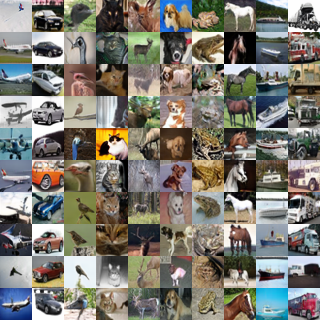

Calculating Inception Score with 50000 images in 10 splits
Inception Score calculation time: 20.966099 s
Inception Score: mean=10.361073, std=0.133243
Calculating FID with 50000 images from each distribution
FID calculation time: 43.155927 s
FID training_set=3.575988
Calculating FID with 50000 images from each distribution
FID calculation time: 42.938113 s
FID test_set=5.690977
iter 99999	iter_time=1.22, warmup_time=182.15, gen_cost=7.10, disc_cost=2.47, gradient_penalty=0.00, disc_real=-0.32, indicator_stat=2.52, disc_fake=-0.15, disc_fake_acc=0.50, disc_real_acc=0.40, disc_acc=0.45, D(Xr)-D(Xf)=-0.17, Wass_dist=0.00, ac_cost=0.02, ac_real_acc=1.00, ac_fake_acc=0.05, inception score=10.36, fid_training_set=3.58, fid_test_set=5.69,
Snapshot created: /content/drive/Shared drives/shared/mix-gan/logs/MIX-MHingeGAN-10G10D-CIFAR-10-conditional-CIFAR-10/snapshots/iter_100000.ckpt


In [32]:
train_data_batch=np.zeros([NUM_GENERATORS*BATCH_SIZE,DATA_DIM], dtype=dtype)
train_label_batch=np.zeros(NUM_GENERATORS*BATCH_SIZE,dtype=int)

# training

while iteration <=ITERS:
    running_lr=gan_learning_rate#*(1-iteration/ITERS)
    start_time = time.time()
    iteration+=1

    # Train generator 
    for i in range(N_GENERATOR):
        session.run(gen_train_op,\
        feed_dict={real_data:train_data_batch,
        lr:running_lr, curr_iter:iteration})
        
    # Train critic
    for i in range(N_CRITIC):
        if GET_LABELS:
            for k in range(NUM_GENERATORS):
                train_data_batch[k*BATCH_SIZE:(k+1)*BATCH_SIZE],train_label_batch[k*BATCH_SIZE:(k+1)*BATCH_SIZE]=next(train_gen)
        else:
            train_data_batch=next(train_gen)
        
        session.run(disc_train_op,
            feed_dict={lr: running_lr,\
                       real_data:train_data_batch,\
                       real_labels:train_label_batch, update_p:(N_CRITIC*iteration+i)%4==0 and ADA,\
                      }
        )
                    
    if iteration<10 or iteration % log_interval == 0:
        iter_end_time = time.time()
        lib.plot.plot('iter_time', iter_end_time - start_time) # this is for calculating iteration time, should not include time for testing, etc.
        warmup()
        lib.plot.plot('warmup_time', time.time() - iter_end_time)
        print('g_w=',session.run(g_w))
        print('d_w=',session.run(d_w))
        #print(session.run([d_p, indicator]))
        generate_image(iteration)
        _gen_cost,\
        _disc_real,_indicator_stat,_disc_fake, _gradient_penalty, _wass_dist, _disc_cost,\
        _disc_real_acc,_disc_fake_acc,_disc_acc,\
        _ac_cost, _ac_real_acc, _ac_fake_acc,\
        = session.run([ gen_cost,\
        disc_real, indicator_stat, disc_fake, gradient_penalty, wass_dist, disc_cost,\
        disc_real_accuracy,disc_fake_accuracy,disc_accuracy,\
        ac_cost, ac_real_acc, ac_fake_acc],
        feed_dict={real_data:train_data_batch,real_labels:train_label_batch, }
        )
        
        lib.plot.plot('gen_cost', _gen_cost)
        # Write logs and save samples
        if N_CRITIC>0:
            lib.plot.plot('disc_cost', _disc_cost)
            lib.plot.plot('gradient_penalty', _gradient_penalty)   
            lib.plot.plot('disc_real', np.mean(_disc_real))
            lib.plot.plot('indicator_stat', np.mean(_indicator_stat))
            lib.plot.plot('disc_fake', np.mean(_disc_fake))
            lib.plot.plot('disc_fake_acc', _disc_fake_acc)
            lib.plot.plot('disc_real_acc', _disc_real_acc)
            lib.plot.plot('disc_acc', _disc_acc)
            lib.plot.plot('D(Xr)-D(Xf)', np.mean(_disc_real)-np.mean(_disc_fake))
            record['D(Xr)-D(Xf)'][counter % num_counter]=np.mean(_disc_real)-np.mean(_disc_fake)
            lib.plot.plot('Wass_dist', _wass_dist)
            record['Wass_dist'][counter % num_counter]=_wass_dist
            lib.plot.plot('ac_cost', _ac_cost) 
            lib.plot.plot('ac_real_acc', _ac_real_acc) 
            lib.plot.plot('ac_fake_acc', _ac_fake_acc)      
        if iteration % (10000) == 0:  
            if DATASET in IMAGE_DATASETS  and NUM_CHANNELS==3:
                _inception_score = get_inception_score(BATCH_SIZE*INCEPTION_BATCHES)
                print('Inception Score: mean=%f, std=%f'% _inception_score)
                lib.plot.plot('inception score', _inception_score[0])
                record['Inception score'][counter % num_counter],record['IS_std'][counter % num_counter]=_inception_score
            for dst in ['training_set','test_set']:
                if dst=='test_set':
                    _gen = inf_gen('TEST') 
                else:
                    _gen = inf_gen('TRAIN')
                _fid = get_fid(BATCH_SIZE*FID_BATCHES,_gen)
                record['FID_'+dst][counter % num_counter]=_fid
                print('FID %s=%f'% (dst, _fid))
                lib.plot.plot('fid_%s'%dst, _fid)
            counter+=1

        lib.plot.flush(log_dir)
    lib.plot.tick()
    # save a snapshot
    if iteration % snapshot_interval == 0:
        pass
        take_snapshot()
    

In [33]:
take_snapshot()

Snapshot created: /content/drive/Shared drives/shared/mix-gan/logs/MIX-MHingeGAN-10G10D-CIFAR-10-conditional-CIFAR-10/snapshots/iter_100001.ckpt


In [34]:
get_inception_score(BATCH_SIZE*INCEPTION_BATCHES)
for dst in ['training_set','test_set']:
  _gen = inf_gen('TRAIN') if dst=='training_set' else inf_gen('TEST')
  _fid = get_fid(BATCH_SIZE*FID_BATCHES,_gen)
  print('FID %s=%f'% (dst, _fid))

Calculating Inception Score with 50000 images in 10 splits
Inception Score calculation time: 20.895972 s
Calculating FID with 50000 images from each distribution
FID calculation time: 43.115243 s
FID training_set=3.640233
Calculating FID with 50000 images from each distribution
FID calculation time: 43.286042 s
FID test_set=5.667606


In [35]:
get_inception_score(50000)

Calculating Inception Score with 50000 images in 10 splits
Inception Score calculation time: 20.769103 s


(10.303837, 0.1461065)

In [36]:
# save statistics into a csv file

import csv 
import codecs
from io import StringIO
names.sort()
eval_mean={}
unbiased_std={}
for key in record:
    for j in range(num_counter):
        if record[key][j]==0:
            record[key]=record[key][:j]
            break
    eval_mean[key]=np.mean(record[key])
    unbiased_std[key]=np.std(record[key],ddof=1)    

class UnicodeWriter:
    def __init__(self, f, dialect=csv.excel, encoding="utf-8-sig", **kwds):
        self.queue = StringIO()
        self.writer = csv.writer(self.queue, dialect=dialect, **kwds)
        self.stream = f
        self.encoder = codecs.getincrementalencoder(encoding)()
    def writerow(self, row):
        '''writerow(unicode) -> None
        This function takes a Unicode string and encodes it to the output.
        '''
        self.writer.writerow([s for s in row])
        data = self.queue.getvalue()
        data = self.encoder.encode(data)
        self.stream.write(data)
        self.queue.truncate(0)
    def writerows(self, rows):
        for row in rows:
            self.writerow(row)
                       
with open(log_dir+'stats.csv', 'wb') as csvfile:
    spamwriter = UnicodeWriter(csvfile, delimiter=',')
    spamwriter.writerow(names)
    line=[]
    for i in range(len(names)):
        line.append(u'%s ± %s'%(str(round(eval_mean[names[i]],3)),str(round(unbiased_std[names[i]],3))))
    spamwriter.writerow(line)
with open(log_dir+'stats.csv', 'a') as csvfile:    
    writer=csv.writer(csvfile)
    line=[]
    for i in range(len(names)):
        line.append(eval_mean[names[i]])
    for i in range(len(names)):
        line.append(unbiased_std[names[i]])
    writer.writerow(line)


/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)


In [37]:
exit()